<a href="https://colab.research.google.com/github/asriva13/PINN/blob/main/Second_Order_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second order equations.

In [1]:
#@title Installs
! apt-get update
! sudo apt-get install texlive-latex-recommended 
! sudo apt install texlive-latex-extra
! sudo apt install dvipng
! sudo apt install cm-super
! pip install dmsh
! pip install optimesh

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:12 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal/main Sources [2,404 kB]
Get:13 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,019 kB]
G

In [6]:
#@title Imports
%matplotlib inline
import jax.numpy as np
import numpy
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax import jacfwd, jacrev
from jax.numpy import linalg
from jax.example_libraries import optimizers


# This import registers the 3D projection, but is otherwise unused.
#from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.colors import LogNorm
import scipy as sc
from mpl_toolkits.axes_grid1 import ImageGrid
import string
import dmsh
import meshio
import optimesh
import meshplex
from numpy import loadtxt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.tri as tri

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

key = random.PRNGKey(0)

In [7]:
#@title Functions

##################
#Definitions relevant to NN architecture.
########################
def ReLU(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return np.maximum(0, x)

def ReLU2(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return (np.maximum(0, np.sign(x)*x**2/2))
    # return (np.maximum(0, x**2/2))

def ReLU3(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return (np.maximum(0, x**3))

def rbf(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return np.exp(-x**2)

def sigmoid(x):
    return 1./(1. + np.exp(-x))

def tanh(x):
    return 2.*sigmoid(2*x)-1.

def relu_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU(np.dot(params[0], x) + params[1])

def rbf_layer(params, x):
    """ Simple ReLu layer for single sample """
    return rbf(np.divide(np.dot(params[0], x),params[1]))
    # return rbf(np.dot(params[0], x))
    

def relu2_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU2(np.dot(params[0], x) + params[1])

def relu3_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU3(np.dot(params[0], x) + params[1])

def sigmoid_layer(params, x):
    """ Simple ReLu layer for single sample """
    return sigmoid(np.dot(params[0], x) + params[1])

def tanh_layer(params, x):
    """ Simple ReLu layer for single sample """
    return tanh(np.dot(params[0], x) + params[1])

############################
############################


###########################
#####Data reshape

def datareshapeMLP(x,numBatches):
  #numpy.random.shuffle(x)
  if numBatches>1:
    l=len(x)
    numCol=int(l/numBatches)
    x=x[:l*numCol]
    x=x.reshape(numBatches,numCol)
  else:
    x=x.reshape(1,len(x))

  return x


############################
###Initialize weights for an MLP
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key, scale=1.e-2):
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

############################

############################
############################
def run_training(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss = update(params, x, opt_state)
      
      train_loss.append(loss)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state

@jit
def update(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value


###########################
###########################
#FE functions
#Linear FE basis function
def psi(x,a,e,m):
  #a=left coordinate
  #b=right coordinate
  #a=intermediate coordinate
  hl = m-a
  hr = e-m
  return ReLU(x-a)/hl - (1./hl + 1./hr)*ReLU(x-m) + ReLU(x-b)/hr
  


####################
#####PDE level functions

#Forcing function
def f(x):
#     return 0
#    return (np.pi**2*k**2)*np.sin(np.pi*k*x)
#    return 100*np.sin(np.pi*k*x)
#    return 1.
#    return np.heaviside(x,.5)
    return np.heaviside(x+.3,.5) -3*np.heaviside(x,.5) + 7*np.heaviside(x-.3,.5)
#    return np.exp(-np.power(x, 2.) / (2 * np.power(.01, 2.)))


def NN(params, x):
    """ Compute the forward pass for each example individually """
    activations = x

    # Loop over the ReLU hidden layers
    for w, b in params[:-1]:
        activations = relu3_layer([w, b], activations)

    final_w, final_b = params[-1]
    final = np.sum(np.dot(final_w, activations)) + final_b

    return (final[0])

def NNRBF(params, x):
    """ Compute the forward pass for each example individually """
    activations = x

    # Loop over the ReLU hidden layers
    for w, b in params[:-1]:
        activations = rbf_layer([w, b], activations)

    final_w, final_b = params[-1]
    final = np.sum(np.dot(final_w, activations)) + final_b*0.

    return (final[0])


def der(params, x):
    return rho1(x,a)*NN(params, x)

def error(params, x):
    ex = e_vect(x)
    e = u_vect(params,x) - e_vect(x)
    return np.sqrt(np.mean(e**2)/np.mean(ex**2))

# def error(params, x):
#     e = u_vect(params,x) - e_vect(x)
#     return np.mean(np.abs(e))

#####################
#Implementing BCs
#Domain boundary
a, b = -1.,1.

#Essential BC
g1, g2 = 0., 0.

#Robin on RHS
c, h = 0., 0.


def phi1(x):
    return x*(1.-x)

def phi2(x):
  return 1 - np.sqrt(x**2 + (1-x)**2)

def rho1(x,a):
  return x-a

def rho2(x,b):
  return b-x

def phiA(x):
  return rho1(x,a)*rho2(x,b)

def phiB(x):
  return rho1(x,a)+rho2(x,b)-np.sqrt(rho1(x,a)**2+rho2(x,b)**2)

def phiD(x):
  s = 2.
  return rho1(x,a)+rho2(x,b)-np.sqrt(rho1(x,a)**2+rho2(x,b)**2)*(rho1(x,a)**2+rho2(x,b)**2)**(s/2)

def phiE(x):
  m = 2.
  return (rho1(x,a)*rho2(x,b))/(rho1(x,a)**m+rho2(x,b)**m)**(1/m)

def phig(x):
  mu = 2.
  return (g1*rho2(x,b)+g2*rho1(x,a))/(rho1(x,a)+rho2(x,b))

epoch:   0 loss: 17.138260
epoch: 1000 loss: 0.054096
epoch: 2000 loss: 0.029063
epoch: 3000 loss: 0.019597
epoch: 4000 loss: 0.016805
epoch: 5000 loss: 0.016292
epoch: 6000 loss: 0.016237
epoch: 7000 loss: 0.016206
epoch: 8000 loss: 0.016150
epoch: 9000 loss: 0.016016
epoch: 10000 loss: 0.015535
epoch: 11000 loss: 0.014556
epoch: 12000 loss: 0.013605
epoch: 13000 loss: 0.012903
epoch: 14000 loss: 0.012400
epoch: 15000 loss: 0.012005
epoch: 16000 loss: 0.011671
epoch: 17000 loss: 0.011376
epoch: 18000 loss: 0.011113
epoch: 19000 loss: 0.010879
epoch: 20000 loss: 0.010670
epoch: 21000 loss: 0.010483
epoch: 22000 loss: 0.010312
epoch: 23000 loss: 0.010157
epoch: 24000 loss: 0.010014
epoch: 25000 loss: 0.009882
epoch: 26000 loss: 0.009759
epoch: 27000 loss: 0.009644
epoch: 28000 loss: 0.009557
epoch: 29000 loss: 0.009436
epoch: 30000 loss: 0.009342
epoch: 31000 loss: 0.009255
epoch: 32000 loss: 0.009171
epoch: 33000 loss: 0.009092
epoch: 34000 loss: 0.009023
epoch: 35000 loss: 0.008947
ep

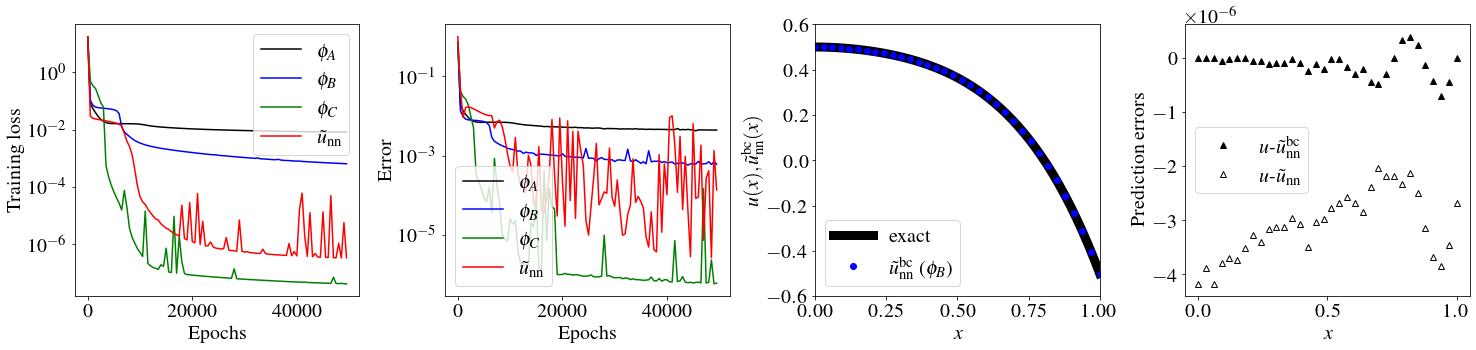

In [10]:
#@title Rod Problem with Dirichlet BC on the two ends
#u''+f=0 on [0,1]

numBatches = 1
num_epochs = 50000
step_size = .5e-3

#Domain boundary
a, b = 0.,1.

a0,a1,a2 = 1.,-2.,10.
g1,g2 = 0.5,-.5

inputx = numpy.linspace(a, b, num=310)
inputx = datareshapeMLP(inputx,numBatches)

#For error
xe = numpy.linspace(a, b, num=50)

#For plotting
x = numpy.linspace(a, b, num=100)


def f(x):
  return a0+a1*x+a2*x**2
f_vect = vmap(f, (0,))

def exact(x):
  c1=g2-g1+a0/2+a1/6+a2/12
  c2=g1
  return -a0*x**2/2 - a1*x**3/6 - a2*x**4/12 + c1*x + c2

grad1e = grad(exact,0)
e_vect = vmap(exact, (0,))
ep_vect = vmap(grad1e, (0,))
ex = e_vect(xe)



#########
#Dirichlet BC on LHS and RHS

layer_sizes = [1, 50, 50, 1]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uA(params, x):
    return phiA(x)*NN(params, x)+phig(x)

def lossA(params, x):
    eq = upp_vect(params,x) + f_vect(x)
    return np.mean(eq**2)

g = grad(grad(uA,1),1)
grad1 = grad(uA,1)
u_vect = vmap(uA, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))


@jit
def updateA(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossA)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

@jit
def errorJA(params, x):
    ex = e_vect(x)
    e = u_vect(params,x) - e_vect(x)
    return np.sqrt(np.mean(e**2)/np.mean(ex**2))

def run_trainingA(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []
    x=inputs[0,:]

    # Get the initial set of parameters
    params = get_params(opt_state)
    paramsA = []

    # Loop over the training epochs
    for epoch in range(num_epochs):

      params, opt_state, loss = updateA(params, x, opt_state)
      Er = errorJA(params,xe)
        
      train_loss.append(loss)
      E.append(Er)
      paramsA.append(params)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E, paramsA

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

lossPhiA, opt_state, errorPhiA, pp = run_trainingA(num_epochs, opt_state, inputx, numBatches)

N = numpy.argmin(lossPhiA)
# params = get_params(opt_state)
params = pp[N]

exactSoln = e_vect(xe)
approxSolnA = u_vect(params, x)
umuhA = u_vect(params, x) - e_vect(x)
umuhpA = up_vect(params, x) - ep_vect(x)
###########################################################


#########
#Dirichlet BC on LHS and RHS

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uB(params, x):
    return phiB(x)*NN(params, x)+phig(x)

def lossB(params, x):
    eq = upp_vect(params,x) + f_vect(x)
    return np.mean(eq**2)

g = grad(grad(uB,1),1)
grad1 = grad(uB,1)
u_vect = vmap(uB, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))

@jit
def updateB(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossB)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

@jit
def errorJB(params, x):
    ex = e_vect(x)
    e = u_vect(params,x) - e_vect(x)
    return np.sqrt(np.mean(e**2)/np.mean(ex**2))

def run_trainingB(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []
    x=inputs[0,:]

    # Get the initial set of parameters
    params = get_params(opt_state)
    paramsA = []

    # Loop over the training epochs
    for epoch in range(num_epochs):

      params, opt_state, loss = updateB(params, x, opt_state)
      Er = errorJB(params,xe)
        
      train_loss.append(loss)
      E.append(Er)
      paramsA.append(params)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E, paramsA

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

lossPhiB, opt_state, errorPhiB, pp = run_trainingB(num_epochs, opt_state, inputx, numBatches)

N = numpy.argmin(lossPhiB)
# params = get_params(opt_state)
params = pp[N]

exactSoln = e_vect(xe)
approxSolnB = u_vect(params, x)
umuhB = u_vect(params, x) - e_vect(x)
umuhpB = up_vect(params, x) - ep_vect(x)
###########################################################





#########
#Dirichlet BC on LHS and RHS

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uE(params, x):
    return phiE(x)*NN(params, x)+phig(x)

def lossE(params, x):
    eq = upp_vect(params,x) + f_vect(x)
    return np.mean(eq**2)

g = grad(grad(uE,1),1)
grad1 = grad(uE,1)
u_vect = vmap(uE, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))

@jit
def updateE(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossE)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

@jit
def errorJE(params, x):
    ex = e_vect(x)
    e = u_vect(params,x) - e_vect(x)
    return np.sqrt(np.mean(e**2)/np.mean(ex**2))

def run_trainingE(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []
    x=inputs[0,:]

    # Get the initial set of parameters
    params = get_params(opt_state)
    paramsA = []

    # Loop over the training epochs
    for epoch in range(num_epochs):

      params, opt_state, loss = updateE(params, x, opt_state)
      Er = errorJE(params,xe)
        
      train_loss.append(loss)
      E.append(Er)
      paramsA.append(params)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E, paramsA

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

lossPhiE, opt_state, errorPhiE, pp = run_trainingE(num_epochs, opt_state, inputx, numBatches)

N = numpy.argmin(lossPhiE)
# params = get_params(opt_state)
params = pp[N]

exactSoln = e_vect(xe)
approxSolnE = u_vect(params, x)
umuhE = u_vect(params, x) - e_vect(x)
umuhpE = up_vect(params, x) - ep_vect(x)
###########################################################


#########
#No Dirichlet applied
def uNBC(params, x):
    return NN(params, x)

def lossNBC(params, x):
    eq = upp_vect(params,x) + f_vect(x)
    bc1 = uNBC(params,a)-g1
    bc2 = uNBC(params,b)-g2
    return np.mean(eq**2) + (bc1**2 + bc2**2)
    # return np.mean(eq**2) + (bc1**2 + bc2**2)/0.01

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

g = grad(grad(uNBC,1),1)
grad1 = grad(uNBC,1)
u_vect = vmap(uNBC, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))

@jit
def updateNBC(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossNBC)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

@jit
def errorNBC(params, x):
    ex = e_vect(x)
    e = u_vect(params,x) - e_vect(x)
    return np.sqrt(np.mean(e**2)/np.mean(ex**2))


def run_trainingNBC(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []
    x=inputs[0,:]

    # Get the initial set of parameters
    params = get_params(opt_state)
    paramsA = []

    ll = 1000000
    pp = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      params, opt_state, loss = updateNBC(params, x, opt_state)
      Er = errorNBC(params,xe)

      if (ll>loss):
        pp = params
        ll = loss
        
      train_loss.append(loss)
      E.append(Er)
      paramsA.append(params)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E, paramsA

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

lossR, opt_state, errorR, pp5 = run_trainingNBC(num_epochs, opt_state, inputx, numBatches)

N = numpy.argmin(lossR)
# params = get_params(opt_state)
params = pp5[N]

exactSoln = e_vect(xe)
approxSolnR = u_vect(params, x)
umuhR = u_vect(params, x) - e_vect(x)
umuhpR = up_vect(params, x) - ep_vect(x)
###########################################################

e_dx=500
plt.rcParams.update({'font.size': 20})
######
#Plots
fig = plt.figure(figsize=(25, 5))
gs = gridspec.GridSpec(1, 4)
gs.update(wspace=.3)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])

ax1.plot(range(num_epochs)[::e_dx],lossPhiA[::e_dx], color="black", label='$\phi_A$')
ax1.plot(range(num_epochs)[::e_dx],lossPhiB[::e_dx], 'blue', label='$\phi_B$')
ax1.plot(range(num_epochs)[::e_dx],lossPhiE[::e_dx], color="green", label='$\phi_C$')
ax1.plot(range(num_epochs)[::e_dx],lossR[::e_dx], color="red", label='$\\tilde{u}_\mathrm{nn}$')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss')
ax1.legend(loc='best')

ax2.plot(range(num_epochs)[::e_dx],errorPhiA[::e_dx], color="black", label='$\phi_A$')
ax2.plot(range(num_epochs)[::e_dx],errorPhiB[::e_dx], color="blue", label='$\phi_B$')
ax2.plot(range(num_epochs)[::e_dx],errorPhiE[::e_dx], color="green", label='$\phi_C$')
ax2.plot(range(num_epochs)[::e_dx],errorR[::e_dx], color="red", label='$\\tilde{u}_\mathrm{nn}$')
ax2.set_yscale('log')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Error')
ax2.legend(loc='best')

ax3.plot(xe, exactSoln, color="black", linewidth=9.0, label='exact')
ax3.plot(x[::3], approxSolnE[::3], 'bo', label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$ ($\phi_B$)')
ax3.legend(loc='best')
ax3.set_xlim(0.,1.)
ax3.set_ylim(-.6,.6)
ax3.set_xlabel('$x$')
ax3.set_ylabel('$u(x),\\tilde{u}_\mathrm{nn}^\mathrm{bc}(x)$')

ax4.plot(x[::3], umuhE[::3], "k^", label='$u$-$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
# ax4.plot(x[::3], umuhpE[::3], "ks", label='$u\'$-$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$$\'$')
ax4.plot(x[::3], umuhR[::3], "k^", mfc='none', label='$u$-$\\tilde{u}_\mathrm{nn}$')
# ax4.plot(x[::3], umuhpR[::3], "ks", mfc='none', label='$u\'$-$\\tilde{u}_\mathrm{nn}$$\'$')
ax4.legend(loc='best')
ax4.set_xlabel('$x$')
ax4.set_ylabel('Prediction errors')

fig.savefig('elasticRod-i.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0.2)
plt.show()



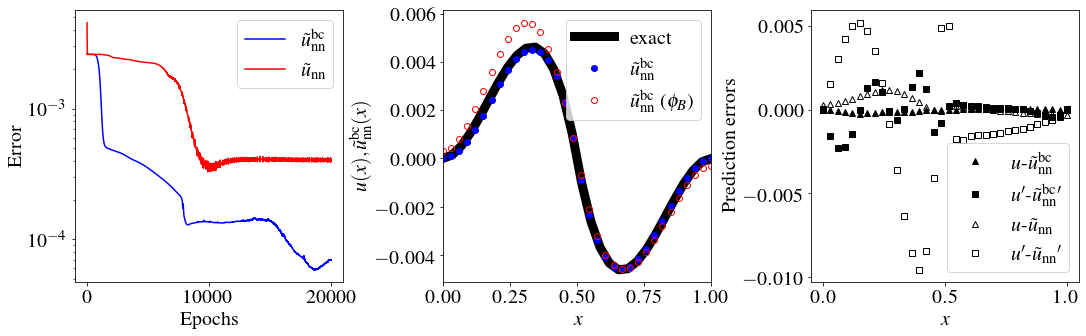

In [ ]:
#@title Kirchoff problem

numBatches = 1
num_epochs = 20000

#Domain boundary
a, b = 0.,1.

def exact(x):
  y=x-0.5
  a,b=-3./2.,1./4.
  return ReLU2(y) + a*x**3/6. + b*x**2/2.

inputx = numpy.linspace(a, b, num=500)
dx=inputx[1]-inputx[0]
inputx = datareshapeMLP(inputx,numBatches)

#For plotting
x = numpy.linspace(a, b, num=100)
xe = numpy.linspace(a, b, num=30)


#########
#Dirichlet BC on LHS and RHS

layer_sizes = [1, 50, 50, 1]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uR(params, x):
    return phiB(x)**2*NN(params, x)

def lossR(params, x):
    eq = upp_vect(params,x)**2
    M = grad1(params,0.5)
    return dx*np.sum(eq)/2.+M

g = grad(grad(uR,1),1)
grad1 = grad(uR,1)
grad1e = grad(exact,0)
u_vect = vmap(uR, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))
e_vect = vmap(exact, (0,))
ep_vect = vmap(grad1e, (0,))
# f_vect = vmap(f, (0,))


def run_trainingR(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = updateR(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateR(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossR)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er


# Defining an optimizer in Jax
step_size = 1e-4
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingR(num_epochs, opt_state, inputx, numBatches)

params = get_params(opt_state)

errorA = e
lossA = train_loss

exactSoln = e_vect(xe)
approxSolnA = u_vect(params, x)
umuhA = u_vect(params, x) - e_vect(x)
umuhpA = up_vect(params, x) - ep_vect(x)
###########################################################


#########
#No Dirichlet applied
def uN(params, x):
    return NN(params, x)

def lossN(params, x):
    eq = upp_vect(params,x)**2
    M = grad1(params,0.5)
    bc1 = uN(params,a)
    bc2 = uN(params,b)
    bc3 = grad1(params,a)
    bc4 = grad1(params,b)
    return dx*np.sum(eq)/2.+M + 10000*(bc1**2 + bc2**2 + bc3**2 + bc4**2)/4.

params = initialize_mlp(layer_sizes, key)

g = grad(grad(uN,1),1)
grad1 = grad(uN,1)
u_vect = vmap(uN, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))



def run_trainingN(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = updateN(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateN(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossN)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er


# Defining an optimizer in Jax
step_size = 1e-4
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingN(num_epochs, opt_state, inputx, numBatches)

params = get_params(opt_state)

errorN = e
lossN = train_loss

approxSolnN = u_vect(params, x)
umuhN = u_vect(params, x) - e_vect(x)
umuhpN = up_vect(params, x) - ep_vect(x)
###########################################################


plt.rcParams.update({'font.size': 20})
######
#Plots
# fig = plt.figure(figsize=(24, 5))
fig = plt.figure(figsize=(18, 5))
gs = gridspec.GridSpec(1, 3)
gs.update(wspace=.37)
# gs.update(hspace=.35)
# ax1 = plt.subplot(gs[0, 0])
# ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 0])
ax3 = plt.subplot(gs[0, 1])
ax4 = plt.subplot(gs[0, 2])

# ax1.plot(range(num_epochs),lossA, color="blue", label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
# ax1.plot(range(num_epochs),lossN, 'red', label='$\\tilde{u}_\mathrm{nn}$')
# # ax1.plot(range(num_epochs),lossPhiD, color="red", label='$\phi_D$')
# # ax1.plot(range(num_epochs),lossPhiE, color="green", label='$\phi_C$')
# # ax1.plot(range(num_epochs),lossR, color="red", label='$\\tilde{u}_\mathrm{nn}$')
# ax1.set_yscale('log')
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Training loss')
# ax1.legend(loc='best')
# # ax1.text(-.1, 1., 'a', size=20, transform=ax1.transAxes)

ax2.plot(range(num_epochs),errorA, color="blue", label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
ax2.plot(range(num_epochs),errorN, color="red", label='$\\tilde{u}_\mathrm{nn}$')
# ax2.plot(range(num_epochs),errorPhiD, color="red", label='$\phi_D$')
# ax2.plot(range(num_epochs),errorPhiE, color="green", label='$\phi_C$')
# ax2.plot(range(num_epochs),errorR, color="red", label='$\\tilde{u}_\mathrm{nn}$')
ax2.set_yscale('log')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Error')
ax2.legend(loc='best')
# ax2.text(-.15, 1., 'b', size=20, transform=ax2.transAxes)

ax3.plot(xe, exactSoln, color="black", linewidth=9.0, label='exact')
ax3.plot(x[::3], approxSolnA[::3], 'bo', label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
ax3.plot(x[::3], approxSolnN[::3], 'ro', mfc='none', label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$ ($\phi_B$)')
ax3.legend(loc='best')
ax3.set_xlim(0.,1.)
# ax3.set_ylim(-.6,.6)
ax3.set_xlabel('$x$')
ax3.set_ylabel('$u(x),\\tilde{u}_\mathrm{nn}^\mathrm{bc}(x)$')
# ax3.text(-.15, 1., 'c', size=20, transform=ax3.transAxes)

ax4.plot(x[::3], umuhA[::3], "k^", label='$u$-$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
ax4.plot(x[::3], umuhpA[::3], "ks", label='$u\'$-$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$$\'$')
ax4.plot(x[::3], umuhN[::3], "k^", mfc='none', label='$u$-$\\tilde{u}_\mathrm{nn}$')
ax4.plot(x[::3], umuhpN[::3], "ks", mfc='none', label='$u\'$-$\\tilde{u}_\mathrm{nn}$$\'$')
ax4.legend(loc='best')
# ax4.set_xlim(0.,1.)
# ax4.set_ylim(-.6,.6)
ax4.set_xlabel('$x$')
ax4.set_ylabel('Prediction errors')
# ax4.text(-.1, 1., 'd', size=20, transform=ax4.transAxes)

fig.savefig('euler-b.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0)
plt.show()


# ###########
# #Dirichlet BC on LHS and Robin on RHS
# def u(params, x):
#     derb = grad(der,1)(params,b)
#     t1 = rho1(x,a)*NN(params, x)
#     t2 = ((rho1(x,a)*rho2(x,b))/(rho1(x,a)+rho2(x,b)))*(rho2(x,b)*NN(params, x)-c*rho1(x,a)*NN(params, x)-derb)
#     t3 = ((rho1(x,a)*rho2(x,b))/(rho1(x,a)+rho2(x,b)))*(h-c*g1)
#     return (t1-t2-t3+g1)

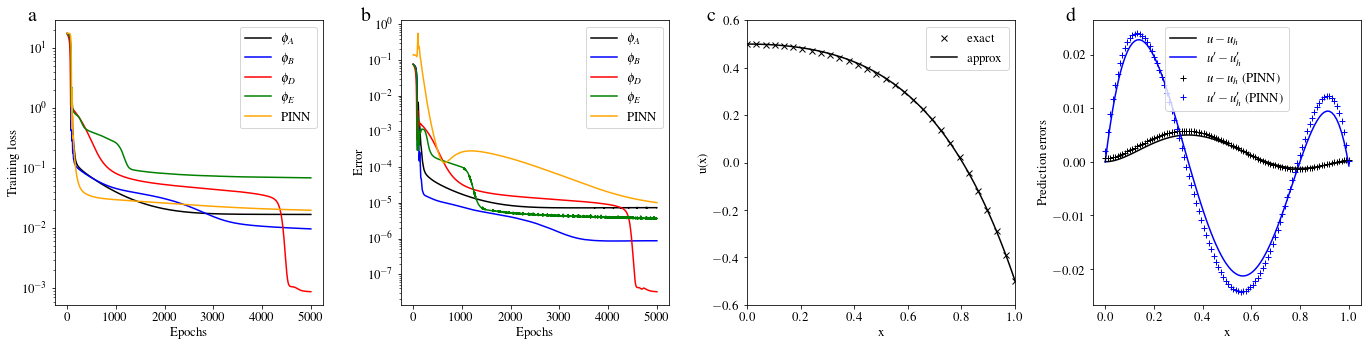

In [ ]:
#@title Extra plots
plt.rcParams.update({'font.size': 13})
######
#Plots
fig = plt.figure(figsize=(24, 5))

# Adds subplot on position 1
ax1 = fig.add_subplot(151)
# Adds subplot on position 2
ax2 = fig.add_subplot(152)
# Adds subplot on position 3
ax3 = fig.add_subplot(153)
# Adds subplot on position 2
ax4 = fig.add_subplot(154)

ax1.plot(range(num_epochs),lossPhiA, color="black", label='$\phi_A$')
ax1.plot(range(num_epochs),lossPhiB, 'blue', label='$\phi_B$')
ax1.plot(range(num_epochs),lossPhiD, color="red", label='$\phi_D$')
ax1.plot(range(num_epochs),lossPhiE, color="green", label='$\phi_E$')
ax1.plot(range(num_epochs),lossR, color="orange", label='PINN')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss')
ax1.legend(loc='best')
ax1.text(-.1, 1., 'a', size=20, transform=ax1.transAxes)

ax2.plot(range(num_epochs),errorPhiA, color="black", label='$\phi_A$')
ax2.plot(range(num_epochs),errorPhiB, color="blue", label='$\phi_B$')
ax2.plot(range(num_epochs),errorPhiD, color="red", label='$\phi_D$')
ax2.plot(range(num_epochs),errorPhiE, color="green", label='$\phi_E$')
ax2.plot(range(num_epochs),errorR, color="orange", label='PINN')
ax2.set_yscale('log')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Error')
ax2.legend(loc='best')
ax2.text(-.15, 1., 'b', size=20, transform=ax2.transAxes)

ax3.plot(xe, exactSoln, 'kx', label='exact')
ax3.plot(x, approxSolnA, color="black", label='approx')
ax3.legend(loc='best')
ax3.set_xlim(0.,1.)
ax3.set_ylim(-.6,.6)
ax3.set_xlabel('x')
ax3.set_ylabel('u(x)')
ax3.text(-.15, 1., 'c', size=20, transform=ax3.transAxes)

ax4.plot(x, umuhA, color="black", label='$u-u_h$')
ax4.plot(x, umuhpA, color="blue", label='$u\'-u_h\'$')
ax4.plot(x, umuhR, "k+", label='$u-u_h$ (PINN)')
ax4.plot(x, umuhpR, "b+", label='$u\'-u_h\'$ (PINN)')
ax4.legend(loc='best')
# ax4.set_xlim(0.,1.)
# ax4.set_ylim(-.6,.6)
ax4.set_xlabel('x')
ax4.set_ylabel('Prediction errors')
ax4.text(-.1, 1., 'd', size=20, transform=ax4.transAxes)

plt.tight_layout()
fig.savefig('elasticRod-i.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

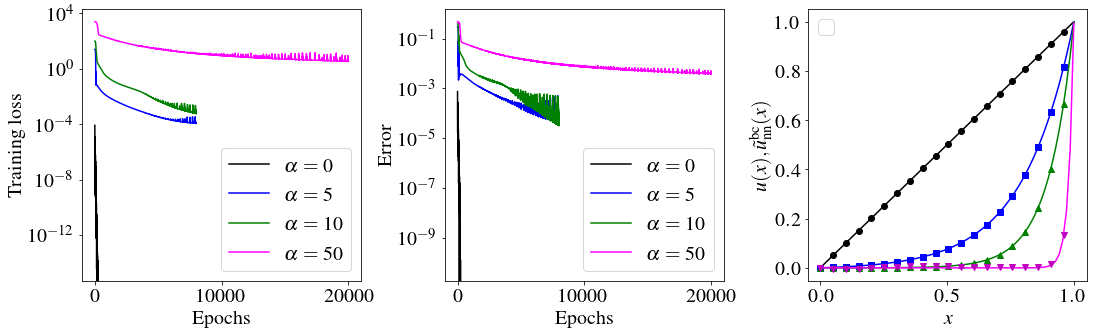

In [ ]:
#@title Advection Diffusion problem

numBatches = 1
num_epochs = 8000

#Domain boundary
a, b = 0.,1.

g1,g2 = 0.,1.

def u(params, x):
    return (phiA(x)*NN(params, x)+ phig(x))

g = grad(grad(u,1),1)
grad1 = grad(u,1)
u_vect = vmap(u, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))

inputx = numpy.linspace(a, b-.0001, num=100)
inputx = datareshapeMLP(inputx,numBatches)

#For plotting
x = numpy.linspace(a, b-.0001, num=100)
xe = numpy.linspace(a, b-.0001, num=70)




# def exact(x):
#   return (np.exp(alpha*x)-1)/(np.exp(alpha)-1)


layer_sizes = [1, 50, 50, 1]
# Return a list of tuples of layer weights





#####################################################

alpha=0.

params = initialize_mlp(layer_sizes, key)

def exact0(x):
  return x

grad1e = grad(exact0,0)
e_vect = vmap(exact0, (0,))
ep_vect = vmap(grad1e, (0,))

def run_training(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = update(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

def loss(params, inputx):
    eq = upp_vect(params,inputx) - alpha*up_vect(params,inputx)
    return np.mean(eq**2)

@jit
def update(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er


# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)
train_loss, opt_state, e = run_training(num_epochs, opt_state, inputx, numBatches)

params = get_params(opt_state)

error0 = e
loss0 = train_loss

exactSoln0 = e_vect(xe)
approxSoln0 = u_vect(params, x)
umuh0 = u_vect(params, x) - e_vect(x)
umuhp0 = up_vect(params, x) - ep_vect(x)
###########################################################

alpha=5.

params = initialize_mlp(layer_sizes, key)

def exact5(x):
  return (np.exp(5.*x)-1)/(np.exp(5.)-1)

grad1e = grad(exact5,0)
e_vect = vmap(exact5, (0,))
ep_vect = vmap(grad1e, (0,))


def run_training5(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = update5(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

def loss5(params, inputx):
    eq = upp_vect(params,inputx) - 5*up_vect(params,inputx)
    return np.mean(eq**2)

@jit
def update5(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss5)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er


# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)
train_loss, opt_state, e = run_training5(num_epochs, opt_state, inputx, numBatches)

params = get_params(opt_state)

error5 = e
loss5 = train_loss

exactSoln5 = e_vect(xe)
approxSoln5 = u_vect(params, x)
umuh5 = u_vect(params, x) - e_vect(x)
umuhp5 = up_vect(params, x) - ep_vect(x)
###########################################################


###########################################################

alpha=10.

params = initialize_mlp(layer_sizes, key)

def exact10(x):
  return (np.exp(10.*x)-1)/(np.exp(10.)-1)

grad1e = grad(exact10,0)
e_vect = vmap(exact10, (0,))
ep_vect = vmap(grad1e, (0,))


def run_training10(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = update10(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

def loss10(params, inputx):
    eq = upp_vect(params,inputx) - 10*up_vect(params,inputx)
    return np.mean(eq**2)

@jit
def update10(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss10)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er



# grad1e = grad(exact,0)
# e_vect = vmap(exact, (0,))
# ep_vect = vmap(grad1e, (0,))


# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)
train_loss, opt_state, e = run_training10(num_epochs, opt_state, inputx, numBatches)

params = get_params(opt_state)

error10 = e
loss10 = train_loss

exactSoln10 = e_vect(xe)
approxSoln10 = u_vect(params, x)
umuh10 = u_vect(params, x) - e_vect(x)
umuhp10 = up_vect(params, x) - ep_vect(x)
###########################################################

num_epochs50 = 20000
layer_sizes = [1, 50, 50, 50, 1]
inputx = numpy.linspace(a, b-.01, num=200)
inputx = datareshapeMLP(inputx,numBatches)
alpha=50.

params = initialize_mlp(layer_sizes, key)

def exact50(x):
  return (np.exp(50.*x)-1)/(np.exp(50.)-1)

grad1e = grad(exact50,0)
e_vect = vmap(exact50, (0,))
ep_vect = vmap(grad1e, (0,))

# grad1e = grad(exact,0)
# e_vect = vmap(exact, (0,))
# ep_vect = vmap(grad1e, (0,))

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)
train_loss, opt_state, e = run_training(num_epochs50, opt_state, inputx, numBatches)

params = get_params(opt_state)

error50 = e
loss50 = train_loss

exactSoln50 = e_vect(xe)
approxSoln50 = u_vect(params, x)
umuh50 = u_vect(params, x) - e_vect(x)
umuhp50 = up_vect(params, x) - ep_vect(x)
###########################################################



plt.rcParams.update({'font.size': 20})
######
#Plots
# fig = plt.figure(figsize=(18, 5))
fig = plt.figure(figsize=(18, 5))
gs = gridspec.GridSpec(1, 3)
gs.update(wspace=.3)
# gs.update(hspace=.35)
# ax1 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
# ax4 = plt.subplot(gs[0, 3])

ax1.plot(range(num_epochs),loss0, color="black", label='$\\alpha = 0$')
ax1.plot(range(num_epochs),loss5, color="blue", label='$\\alpha = 5$')
ax1.plot(range(num_epochs),loss10, color="green", label='$\\alpha = 10$')
ax1.plot(range(num_epochs50),loss50, color="magenta", label='$\\alpha = 50$')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss')
ax1.legend(loc='best')
# ax1.text(-.1, 1., 'a', size=20, transform=ax1.transAxes)

ax2.plot(range(num_epochs),error0, color="black", label='$\\alpha = 0$')
ax2.plot(range(num_epochs),error5, color="blue", label='$\\alpha = 5$')
ax2.plot(range(num_epochs),error10, color="green", label='$\\alpha = 10$')
ax2.plot(range(num_epochs50),error50, color="magenta", label='$\\alpha = 50$')
ax2.set_yscale('log')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Error')
ax2.legend(loc='best')
# ax2.text(-.15, 1., 'b', size=20, transform=ax2.transAxes)

ax3.plot(xe, exactSoln0, color="black")
ax3.plot(x[::5], approxSoln0[::5], 'ko')
ax3.plot(xe, exactSoln5, color="blue")
ax3.plot(x[::5], approxSoln5[::5], 'bs')
ax3.plot(xe, exactSoln10, color="green")
ax3.plot(x[::5], approxSoln10[::5], 'g^')
ax3.plot(xe, exactSoln50, color="magenta")
ax3.plot(x[::5], approxSoln50[::5], 'mv')
# ax3.plot(x, approxSolnR, color="orange", label='approx (PINN)')
ax3.legend(loc='best')
# ax3.set_xlim(0.,1.)
# ax3.set_ylim(-.6,.6)
ax3.set_xlabel('$x$')
ax3.set_ylabel('$u(x),\\tilde{u}_\mathrm{nn}^\mathrm{bc}(x)$')
# ax3.text(-.15, 1., 'c', size=20, transform=ax3.transAxes)

fig.savefig('AD1.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

epoch:   0 loss: 17.310143
epoch: 1000 loss: 0.000080
epoch: 2000 loss: 0.000031
epoch: 3000 loss: 0.000029
epoch: 4000 loss: 0.000029
epoch: 5000 loss: 0.000029
epoch: 6000 loss: 0.000029
epoch: 7000 loss: 0.000029
epoch:   0 loss: 17.370035
epoch: 1000 loss: 1.224491
epoch: 2000 loss: 1.053981
epoch: 3000 loss: 0.935425
epoch: 4000 loss: 0.844680
epoch: 5000 loss: 0.298765
epoch: 6000 loss: 0.007679
epoch: 7000 loss: 0.002839


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:232: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


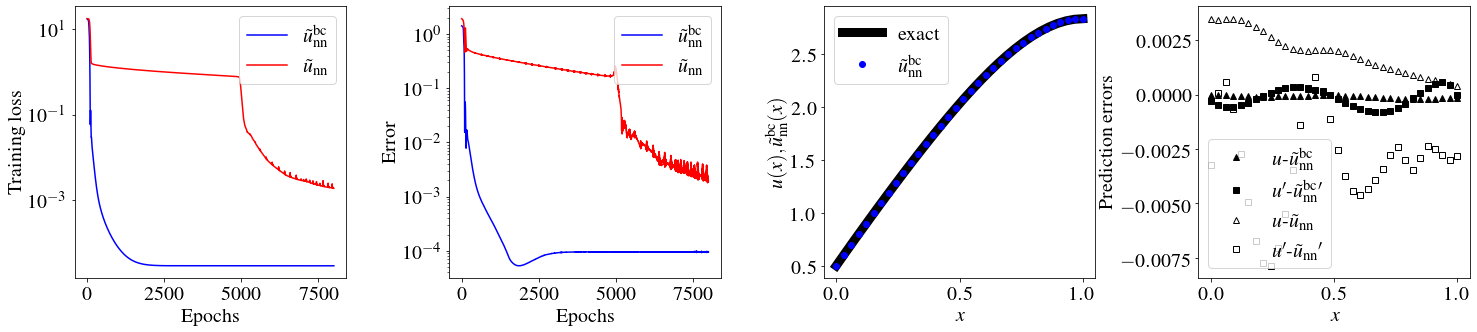

In [ ]:
#@title Rod Problem with Dirichlet BC on the left end and Robin on LHS
#u''+f=0 on [0,1]

numBatches = 1
num_epochs = 8000

#Domain boundary
a, b = 0.,1.

a0,a1,a2 = 1.,-2.,10.
c,g1,g2 = 0.,0.5,0.

def f(x):
  return a0+a1*x+a2*x**2

def exact(x):
  c2 = g1
  c1 = (1/(1+c))*(g2+c*(-g1+a0/2.+a1/6.+a2/12.)+(a0+a1/2.+a2/3.))
  return -a0*x**2/2 - a1*x**3/6 - a2*x**4/12 + c1*x + c2

inputx = numpy.linspace(a, b, num=100)
inputx = datareshapeMLP(inputx,numBatches)

#For plotting
x = numpy.linspace(a, b, num=100)
xe = numpy.linspace(a, b, num=30)


#########
#Dirichlet BC on LHS and robin on RHS
def u(params, x):
    derb = grad(der,1)(params,b)
    t1 = rho1(x,a)*NN(params, x)
    t2 = ((rho1(x,a)*rho2(x,b))/(rho1(x,a)+rho2(x,b)))*(rho2(x,b)*NN(params, x)-c*rho1(x,a)*NN(params, x)-derb)
    t3 = ((rho1(x,a)*rho2(x,b))/(rho1(x,a)+rho2(x,b)))*(h-c*g1)
    return (t1-t2-t3+g1)


layer_sizes = [1, 50, 50, 1]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def loss(params, x):
    eq = upp_vect(params,x) + f_vect(x)
    return np.mean(eq**2)

g = grad(grad(u,1),1)
grad1 = grad(u,1)
grad1e = grad(exact,0)
u_vect = vmap(u, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))
e_vect = vmap(exact, (0,))
ep_vect = vmap(grad1e, (0,))
f_vect = vmap(f, (0,))


def run_training(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = update(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def update(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er


# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_training(num_epochs, opt_state, inputx, numBatches)

params = get_params(opt_state)

errorPhiA = e
lossPhiA = train_loss

exactSoln = e_vect(xe)
approxSolnA = u_vect(params, x)
umuhA = u_vect(params, x) - e_vect(x)
umuhpA = up_vect(params, x) - ep_vect(x)
###########################################################


#########
#No BC applied
def u(params, x):
    return NN(params, x)

def loss(params, x):
    eq = upp_vect(params,x) + f_vect(x)
    bc1 = u(params,a)-g1
    bc2 = c*u(params,b)+grad1(params,b)-g2
    return np.mean(eq**2) + (bc1**2 + bc2**2)/2.

layer_sizes = [1, 50, 50, 1]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

g = grad(grad(u,1),1)
grad1 = grad(u,1)
grad1e = grad(exact,0)
u_vect = vmap(u, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))
e_vect = vmap(exact, (0,))
ep_vect = vmap(grad1e, (0,))
f_vect = vmap(f, (0,))


def run_training(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = update(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def update(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er


# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_training(num_epochs, opt_state, inputx, numBatches)

params = get_params(opt_state)

errorR = e
lossR = train_loss

exactSoln = e_vect(xe)
approxSolnR = u_vect(params, x)
umuhR = u_vect(params, x) - e_vect(x)
umuhpR = up_vect(params, x) - ep_vect(x)
###########################################################




plt.rcParams.update({'font.size': 20})
######
#Plots
fig = plt.figure(figsize=(25, 5))
gs = gridspec.GridSpec(1, 4)
gs.update(wspace=.38)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])

ax1.plot(range(num_epochs),lossPhiA, color="blue", label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
ax1.plot(range(num_epochs),lossR, color="red", label='$\\tilde{u}_\mathrm{nn}$')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss')
ax1.legend(loc='best')

ax2.plot(range(num_epochs),errorPhiA, color="blue", label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
ax2.plot(range(num_epochs),errorR, color="red", label='$\\tilde{u}_\mathrm{nn}$')
ax2.set_yscale('log')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Error')
ax2.legend(loc='best')

ax3.plot(xe, exactSoln, color="black", label='exact', linewidth=9.0)
ax3.plot(x[::3], approxSolnA[::3], 'bo', label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
ax3.legend(loc='best')
ax3.set_xlabel('$x$')
ax3.set_ylabel('$u(x),\\tilde{u}_\mathrm{nn}^\mathrm{bc}(x)$')

ax4.plot(x[::3], umuhA[::3], "k^", label='$u$-$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
ax4.plot(x[::3], umuhpA[::3], "ks", label='$u\'$-$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$$\'$')
ax4.plot(x[::3], umuhR[::3], "k^", mfc='none', label='$u$-$\\tilde{u}_\mathrm{nn}$')
ax4.plot(x[::3], umuhpR[::3], "ks", mfc='none', label='$u\'$-$\\tilde{u}_\mathrm{nn}$$\'$')
ax4.legend(loc='best')
ax4.set_xlabel('$x$')
ax4.set_ylabel('Prediction errors')


plt.tight_layout()
fig.savefig('elasticRod-ii.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

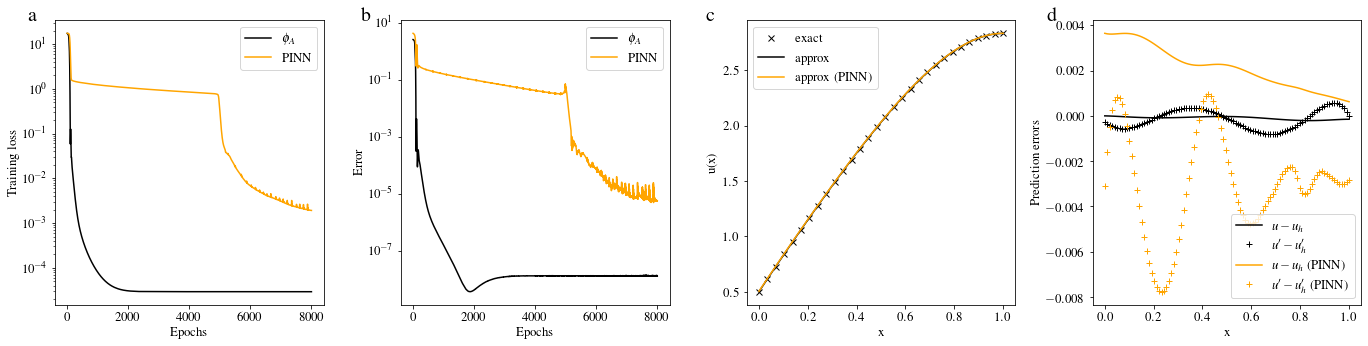

In [ ]:
#@title Extra plots

plt.rcParams.update({'font.size': 13})
######
#Plots
fig = plt.figure(figsize=(24, 5))

# Adds subplot on position 1
ax1 = fig.add_subplot(151)
# Adds subplot on position 2
ax2 = fig.add_subplot(152)
# Adds subplot on position 3
ax3 = fig.add_subplot(153)
# Adds subplot on position 2
ax4 = fig.add_subplot(154)

ax1.plot(range(num_epochs),lossPhiA, color="black", label='$\phi_A$')
ax1.plot(range(num_epochs),lossR, color="orange", label='PINN')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss')
ax1.legend(loc='best')
ax1.text(-.1, 1., 'a', size=20, transform=ax1.transAxes)

ax2.plot(range(num_epochs),errorPhiA, color="black", label='$\phi_A$')
ax2.plot(range(num_epochs),errorR, color="orange", label='PINN')
ax2.set_yscale('log')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Error')
ax2.legend(loc='best')
ax2.text(-.15, 1., 'b', size=20, transform=ax2.transAxes)

ax3.plot(xe, exactSoln, 'kx', label='exact')
ax3.plot(x, approxSolnA, color="black", label='approx')
ax3.plot(x, approxSolnR, color="orange", label='approx (PINN)')
ax3.legend(loc='best')
# ax3.set_xlim(0.,1.)
# ax3.set_ylim(-.6,.6)
ax3.set_xlabel('x')
ax3.set_ylabel('u(x)')
ax3.text(-.15, 1., 'c', size=20, transform=ax3.transAxes)

ax4.plot(x, umuhA, color="black", label='$u-u_h$')
ax4.plot(x, umuhpA, "k+", label='$u\'-u_h\'$')
ax4.plot(x, umuhR, color="orange", label='$u-u_h$ (PINN)')
ax4.plot(x, umuhpR, "+", color='orange', label='$u\'-u_h\'$ (PINN)')
ax4.legend(loc='best')
# ax4.set_xlim(0.,1.)
# ax4.set_ylim(-.6,.6)
ax4.set_xlabel('x')
ax4.set_ylabel('Prediction errors')
ax4.text(-.17, 1., 'd', size=20, transform=ax4.transAxes)

plt.tight_layout()
fig.savefig('elasticRod-ii.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


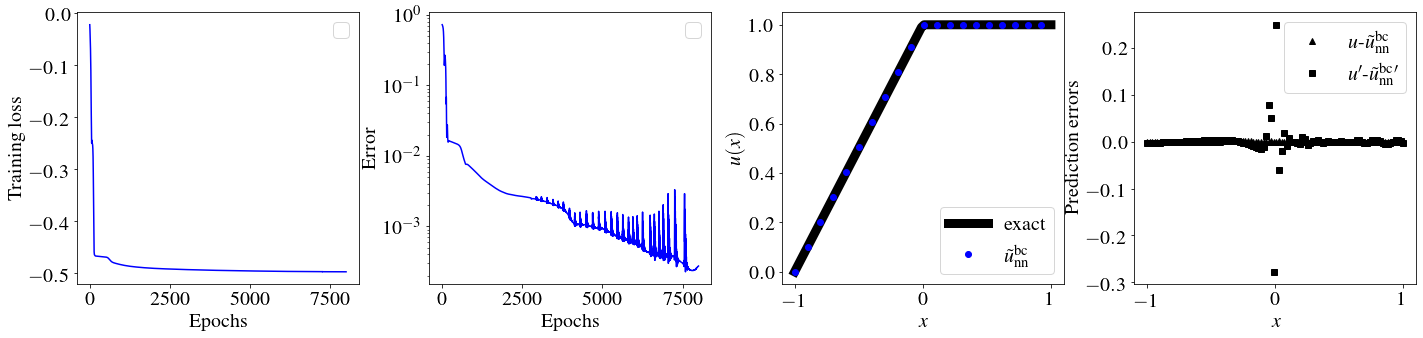

In [ ]:
#@title Elastic rod Ritz

numBatches = 1
num_epochs = 8000

#Domain boundary
a, b = -1.,1.

g1 = 0.
c,h,g2 = 0.,0.,0.
x0 = 0.

def H(x):
  return np.heaviside(x,x0)

def ramp(x):
  return ReLU(x-x0)

def exact(x):
  c1 = g2+H(b)
  c2 = (g1-c1+ramp(a))/a
  return -ramp(x) + c1*x +c2

# def f(x):
#   return a0+a1*x+a2*x**2

# def exact(x):
#   c2 = g1
#   c1 = (1/(1+c))*(g2+c*(-g1+a0/2.+a1/6.+a2/12.)+(a0+a1/2.+a2/3.))
#   return -a0*x**2/2 - a1*x**3/6 - a2*x**4/12 + c1*x + c2

inputx = numpy.linspace(a, b, num=100)
inputx = datareshapeMLP(inputx,numBatches)

#For plotting
x = numpy.linspace(a, b, num=100)
xe = numpy.linspace(a, b, num=100)


def u(params, x):
    return rho1(x,a)*NN(params, x)+g1

def A(params, x):
    return 0.5*(grad(u,1)(params,x))**2

def L(params, x):
    return f(x)*u(params,x)

A_vect = vmap(A, (None, 0))
L_vect = vmap(L, (None, 0))
u_vect = vmap(u, (None, 0))

def loss(params, inputx):
    eq = A_vect(params,inputx)
    return np.trapz(eq,inputx) -u(params,x0) + c*u(params,b)**2 - h*u(params,b)

layer_sizes = [1, 50, 50, 50, 1]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

g = grad(grad(u,1),1)
grad1 = grad(u,1)
grad1e = grad(exact,0)
u_vect = vmap(u, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))
e_vect = vmap(exact, (0,))
ep_vect = vmap(grad1e, (0,))
f_vect = vmap(f, (0,))


def run_training(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = update(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def update(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er


# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_training(num_epochs, opt_state, inputx, numBatches)

params = get_params(opt_state)

errorR = e
lossR = train_loss

exactSoln = e_vect(xe)
approxSolnR = u_vect(params, x)
umuhR = u_vect(params, x) - e_vect(x)
umuhpR = up_vect(params, x) - ep_vect(x)
###########################################################


plt.rcParams.update({'font.size': 20})
######
#Plots
# fig = plt.figure(figsize=(24, 5))
fig = plt.figure(figsize=(24, 5))
gs = gridspec.GridSpec(1, 4)
gs.update(wspace=.25)
# gs.update(hspace=.35)
# ax1 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])


ax1.plot(range(num_epochs),lossR, color="blue")
# ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss')
ax1.legend(loc='best')
# ax1.text(-.1, 1., 'a', size=20, transform=ax1.transAxes)

ax2.plot(range(num_epochs),errorR, color="blue")
ax2.set_yscale('log')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Error')
ax2.legend(loc='best')
# ax2.text(-.1, 1., 'b', size=20, transform=ax2.transAxes)

ax3.plot(xe, exactSoln, color="black", label='exact', linewidth=9.0)
ax3.plot(x[::5], approxSolnR[::5], 'bo', label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
ax3.legend(loc='best')
# ax3.set_xlim(0.,1.)
# ax3.set_ylim(-.6,.6)
ax3.set_xlabel('$x$')
ax3.set_ylabel('$u(x)$')
# ax3.text(-.1, 1., 'c', size=20, transform=ax3.transAxes)

ax4.plot(x, umuhR, "k^", label='$u$-$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
ax4.plot(x, umuhpR, "ks", label='$u\'$-$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$$\'$')
# ax4.plot(x[::2], umuhR[::2], "k^", mfc='none', label='$u$-$\\tilde{u}_\mathrm{nn}$')
# ax4.plot(x[::2], umuhpR[::2], "ks", mfc='none', label='$u\'$-$\\tilde{u}_\mathrm{nn}$$\'$')
ax4.legend(loc='best')
ax4.set_xlabel('$x$')
ax4.set_ylabel('Prediction errors')


plt.tight_layout()
fig.savefig('elasticRod-Ritz1.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0)
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


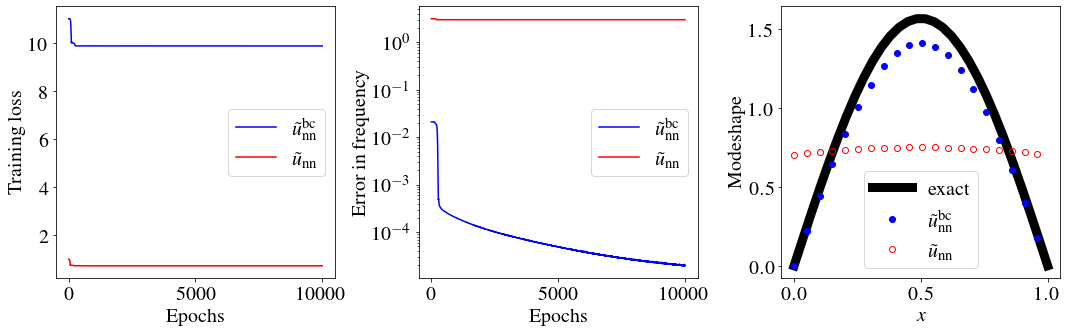

In [ ]:
#@title Ritz Eigenvalue problem
#u''+w^2u=0

numBatches = 1
num_epochs = 10000

#Domain boundary
a, b = 0.,1.

g1,g2 = 0.,0.

inputx = numpy.linspace(a, b, num=100)
inputx = datareshapeMLP(inputx,numBatches)

#For plotting
x = numpy.linspace(a, b, num=100)
xe = numpy.linspace(a, b, num=30)

def error(params, x):
    num = A_vect(params,x)
    den = L_vect(params,x)
    sol = (np.sqrt((np.trapz(num,x)/np.trapz(den,x))))
    e = sol - np.pi
    return np.abs(e)

def exact(x):
    return np.sin(np.pi*x)*(np.pi/2)

grad1e = grad(exact,0)
e_vect = vmap(exact, (0,))
ep_vect = vmap(grad1e, (0,))


layer_sizes = [1, 50, 50, 50, 1]
params = initialize_mlp(layer_sizes, key)

def numeratorR(params, x):
    return (grad(uR,1)(params,x))**2

def denominatorR(params, x):
    return (uR(params,x))**2

A_vect = vmap(numeratorR, (None, 0))
L_vect = vmap(denominatorR, (None, 0))
# Return a list of tuples of layer weights

def run_trainingR(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = updateR(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateR(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossR)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er



###################################################

def uR(params, x):
    return phiA(x)*NN(params, x)+phig(x)

def lossR(params, inputx):
    num = A_vect(params,inputx)
    den = L_vect(params,inputx)
    return np.trapz(num,inputx)/np.trapz(den,inputx) + (np.trapz(den,inputx) - 1)**2

u_vect = vmap(uR, (None, 0))

g = grad(grad(uR,1),1)
grad1 = grad(uR,1)
u_vect = vmap(uR, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingR(num_epochs, opt_state, inputx, numBatches)

params = get_params(opt_state)
errorBC = e
lossBC = train_loss

exactSoln = e_vect(xe)
approxSolnBC = u_vect(params, x)


###################################################

params = initialize_mlp(layer_sizes, key)

def numeratorN(params, x):
    return (grad(uN,1)(params,x))**2

def denominatorN(params, x):
    return (uN(params,x))**2

A_vect = vmap(numeratorN, (None, 0))
L_vect = vmap(denominatorN, (None, 0))

def uN(params, x):
    return NN(params, x)

def lossN(params, inputx):
    num = A_vect(params,inputx)
    den = L_vect(params,inputx)
    bc1 = uN(params,a)
    bc2 = uN(params,b)
    return np.trapz(num,inputx)/np.trapz(den,inputx) + (np.trapz(den,inputx) - 1)**2 + (bc1**2 + bc2**2)/2.

u_vect = vmap(uN, (None, 0))

g = grad(grad(uN,1),1)
grad1 = grad(uN,1)
u_vect = vmap(uN, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))

def run_trainingN(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = updateN(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateN(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossN)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er


# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingN(num_epochs, opt_state, inputx, numBatches)

params = get_params(opt_state)
errorNBC = e
lossNBC = train_loss

exactSoln = e_vect(xe)
approxSolnNBC = u_vect(params, x)

#####################################################



plt.rcParams.update({'font.size': 20})
######
#Plots
# fig = plt.figure(figsize=(24, 5))
fig = plt.figure(figsize=(18, 5))
gs = gridspec.GridSpec(1, 3)
gs.update(wspace=.3)
# gs.update(hspace=.35)
# ax1 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
# ax4 = plt.subplot(gs[0, 3])


ax1.plot(range(num_epochs),lossBC, color="blue", label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
ax1.plot(range(num_epochs),lossNBC, color="red", label='$\\tilde{u}_\mathrm{nn}$')
# ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss')
ax1.legend(loc='best')
# ax1.text(-.1, 1., 'a', size=20, transform=ax1.transAxes)

ax2.plot(range(num_epochs),errorBC, color="blue", label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
ax2.plot(range(num_epochs),errorNBC, color="red", label='$\\tilde{u}_\mathrm{nn}$')
ax2.set_yscale('log')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Error in frequency')
ax2.legend(loc='best')
# ax2.text(-.1, 1., 'b', size=20, transform=ax2.transAxes)

ax3.plot(xe, exactSoln, color="black", label='exact', linewidth=9.0)
ax3.plot(x[::5], approxSolnBC[::5], 'bo', label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
ax3.plot(x[::5], approxSolnNBC[::5], 'ro', mfc='none', label='$\\tilde{u}_\mathrm{nn}$')
ax3.legend(loc='best')
# ax3.set_xlim(0.,1.)
# ax3.set_ylim(-.6,.6)
ax3.set_xlabel('$x$')
ax3.set_ylabel('Modeshape')
# ax3.text(-.1, 1., 'c', size=20, transform=ax3.transAxes)

# ax4.plot(x, umuhA, color="black", label='$u-u_h$')
# ax4.plot(x, umuhpA, "k+", label='$u\'-u_h\'$')
# ax4.plot(x, umuhR, color="orange", label='$u-u_h$ (PINN)')
# ax4.plot(x, umuhpR, "+", color='orange', label='$u\'-u_h\'$ (PINN)')
# ax4.legend(loc='best')
# # ax4.set_xlim(0.,1.)
# # ax4.set_ylim(-.6,.6)
# ax4.set_xlabel('x')
# ax4.set_ylabel('Prediction errors')
# ax4.text(-.17, 1., 'd', size=20, transform=ax4.transAxes)

plt.tight_layout()
fig.savefig('Ritz-eig1.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


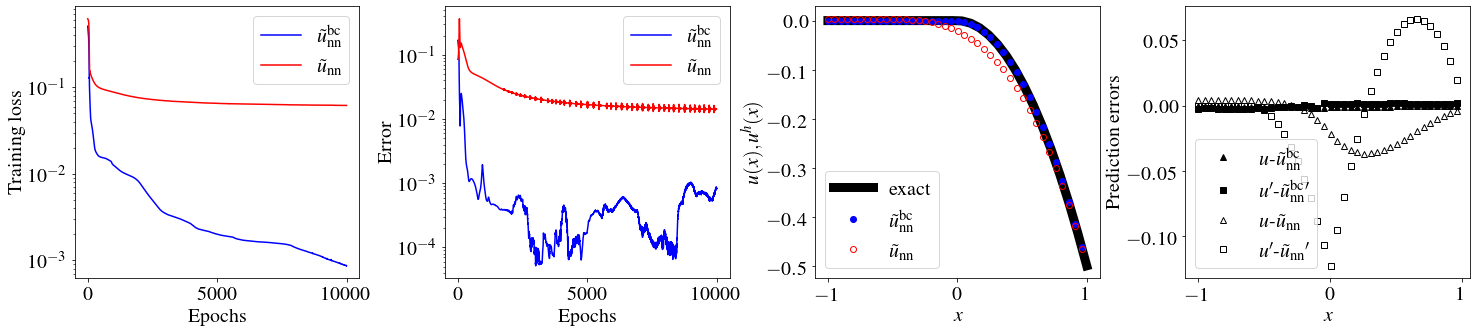

In [ ]:
#@title Elastic rod with a discontinuous (Heaviside) body force

numBatches = 1
num_epochs = 10000

#Domain boundary
a, b = -1.,1.

x0, epsilon = 0., 1E-2
def H(x):
  return np.heaviside(x,x0)

def ramp(x):
  return ReLU(x-x0)

def ramp2(x):
  return ReLU2(x-x0)

g1,g2 = 0.,-0.5


########################
#Heaviside function

def f(x):
  return H(x)

def exact(x):
  c2 = (g1+g2+ramp2(-1.)+ramp2(1.))/2.
  c1 = (-g1+g2-ramp2(-1.)+ramp2(1.))/2.
  return -ramp2(x) + c1*x +c2

inputx = numpy.linspace(a, b, num=100)
inputx = datareshapeMLP(inputx,numBatches)

#For plotting
x = numpy.linspace(a, b, num=200)
xe = numpy.linspace(a, b, num=30)


#########
#Dirichlet BC on LHS and RHS

layer_sizes = [1, 50, 50, 1]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def u(params, x):
    return phiA(x)*NN(params, x)+phig(x)

def loss(params, x):
    eq = upp_vect(params,x) + f_vect(x)
    return np.mean(eq**2)

g = grad(grad(u,1),1)
grad1 = grad(u,1)
grad1e = grad(exact,0)
u_vect = vmap(u, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))
e_vect = vmap(exact, (0,))
ep_vect = vmap(grad1e, (0,))
f_vect = vmap(f, (0,))


def run_training(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = update(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def update(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er


# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_training(num_epochs, opt_state, inputx, numBatches)

params = get_params(opt_state)

errorPhiA = e
lossPhiA = train_loss

exactSoln = e_vect(xe)
approxSolnA = u_vect(params, x)
umuhA = u_vect(params, x) - e_vect(x)
umuhpA = up_vect(params, x) - ep_vect(x)
###########################################################


#########
#No Dirichlet applied
def u(params, x):
    return NN(params, x)

def loss(params, x):
    eq = upp_vect(params,x) + f_vect(x)
    bc1 = u(params,a)-g1
    bc2 = u(params,b)-g2
    return np.mean(eq**2) + (bc1**2 + bc2**2)/2.

layer_sizes = [1, 50, 50, 1]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

g = grad(grad(u,1),1)
grad1 = grad(u,1)
grad1e = grad(exact,0)
u_vect = vmap(u, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))
e_vect = vmap(exact, (0,))
ep_vect = vmap(grad1e, (0,))
f_vect = vmap(f, (0,))


def run_training(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = update(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def update(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er


# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_training(num_epochs, opt_state, inputx, numBatches)

params = get_params(opt_state)

errorR = e
lossR = train_loss

exactSoln = e_vect(xe)
approxSolnR = u_vect(params, x)
umuhR = u_vect(params, x) - e_vect(x)
umuhpR = up_vect(params, x) - ep_vect(x)
###########################################################



plt.rcParams.update({'font.size': 20})
######
#Plots
# fig = plt.figure(figsize=(24, 5))
fig = plt.figure(figsize=(25, 5))
gs = gridspec.GridSpec(1, 4)
gs.update(wspace=.3)
# gs.update(hspace=.35)
# ax1 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])


ax1.plot(range(num_epochs),lossPhiA, color="blue", label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
ax1.plot(range(num_epochs),lossR, color="red", label='$\\tilde{u}_\mathrm{nn}$')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss')
ax1.legend(loc='best')
# ax1.text(-.1, 1., 'a', size=20, transform=ax1.transAxes)

ax2.plot(range(num_epochs),errorPhiA, color="blue", label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
ax2.plot(range(num_epochs),errorR, color="red", label='$\\tilde{u}_\mathrm{nn}$')
ax2.set_yscale('log')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Error')
ax2.legend(loc='best')
# ax2.text(-.15, 1., 'b', size=20, transform=ax2.transAxes)

ax3.plot(xe, exactSoln, color="black", label='exact', linewidth=9.0)
ax3.plot(x[::5], approxSolnA[::5], 'bo', label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
ax3.plot(x[::5], approxSolnR[::5], 'ro', mfc='none', label='$\\tilde{u}_\mathrm{nn}$')
ax3.legend(loc='best')
ax3.set_xlabel('$x$')
ax3.set_ylabel('$u(x),u^h(x)$')
# ax3.text(-.15, 1., 'c', size=20, transform=ax3.transAxes)

ax4.plot(x[::5], umuhA[::5], "k^", label='$u$-$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
ax4.plot(x[::5], umuhpA[::5], "ks", label='$u\'$-$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$$\'$')
ax4.plot(x[::5], umuhR[::5], "k^", mfc='none', label='$u$-$\\tilde{u}_\mathrm{nn}$')
ax4.plot(x[::5], umuhpR[::5], "ks", mfc='none', label='$u\'$-$\\tilde{u}_\mathrm{nn}$$\'$')
ax4.legend(loc='best')
ax4.set_xlabel('$x$')
ax4.set_ylabel('Prediction errors')

plt.tight_layout()
fig.savefig('heaviside1.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

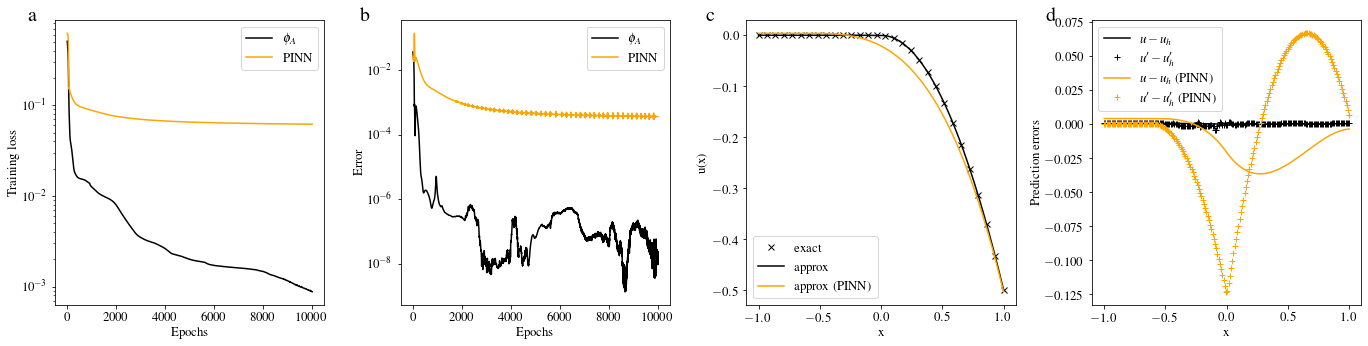

In [ ]:
#@title Extra plots

plt.rcParams.update({'font.size': 13})
######
#Plots
fig = plt.figure(figsize=(24, 5))

# Adds subplot on position 1
ax1 = fig.add_subplot(151)
# Adds subplot on position 2
ax2 = fig.add_subplot(152)
# Adds subplot on position 3
ax3 = fig.add_subplot(153)
# Adds subplot on position 2
ax4 = fig.add_subplot(154)

ax1.plot(range(num_epochs),lossPhiA, color="black", label='$\phi_A$')
ax1.plot(range(num_epochs),lossR, color="orange", label='PINN')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss')
ax1.legend(loc='best')
ax1.text(-.1, 1., 'a', size=20, transform=ax1.transAxes)

ax2.plot(range(num_epochs),errorPhiA, color="black", label='$\phi_A$')
ax2.plot(range(num_epochs),errorR, color="orange", label='PINN')
ax2.set_yscale('log')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Error')
ax2.legend(loc='best')
ax2.text(-.15, 1., 'b', size=20, transform=ax2.transAxes)

ax3.plot(xe, exactSoln, 'kx', label='exact')
ax3.plot(x, approxSolnA, color="black", label='approx')
ax3.plot(x, approxSolnR, color="orange", label='approx (PINN)')
ax3.legend(loc='best')
# ax3.set_xlim(0.,1.)
# ax3.set_ylim(-.6,.6)
ax3.set_xlabel('x')
ax3.set_ylabel('u(x)')
ax3.text(-.15, 1., 'c', size=20, transform=ax3.transAxes)

ax4.plot(x, umuhA, color="black", label='$u-u_h$')
ax4.plot(x, umuhpA, "k+", label='$u\'-u_h\'$')
ax4.plot(x, umuhR, color="orange", label='$u-u_h$ (PINN)')
ax4.plot(x, umuhpR, "+", color='orange', label='$u\'-u_h\'$ (PINN)')
ax4.legend(loc='best')
# ax4.set_xlim(0.,1.)
# ax4.set_ylim(-.6,.6)
ax4.set_xlabel('x')
ax4.set_ylabel('Prediction errors')
ax4.text(-.17, 1., 'd', size=20, transform=ax4.transAxes)

plt.tight_layout()
fig.savefig('heaviside.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

In [ ]:
#@title viii

numBatches = 1
num_epochs = 10000

#Domain boundary
a, b = 0.,1.

g1,g2 = 0.,1.


########################

def f(x):
  return (2./9.)*x**(-4./3)

def exact(x):
  return x**(2./3)

inputx = numpy.linspace(a+.01, b, num=100)
inputx = datareshapeMLP(inputx,numBatches)

#For plotting
x = numpy.linspace(a, b, num=200)
xe = numpy.linspace(a, b, num=30)


#########
#Dirichlet BC on LHS and RHS

layer_sizes = [1, 50, 50, 1]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def u(params, x):
    return phiA(x)*NN(params, x)+phig(x)

def loss(params, x):
    eq = upp_vect(params,x) + f_vect(x)
    return np.mean(eq**2)

g = grad(grad(u,1),1)
grad1 = grad(u,1)
grad1e = grad(exact,0)
u_vect = vmap(u, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))
e_vect = vmap(exact, (0,))
ep_vect = vmap(grad1e, (0,))
f_vect = vmap(f, (0,))

def error(params, x):
    e = u_vect(params,x) - e_vect(x)
    return np.mean(e**2)


def run_training(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = update(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def update(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er


# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_training(num_epochs, opt_state, inputx, numBatches)

params = get_params(opt_state)

errorPhiA = e
lossPhiA = train_loss

exactSoln = e_vect(xe)
approxSolnA = u_vect(params, x)
umuhA = u_vect(params, x) - e_vect(x)
umuhpA = up_vect(params, x) - ep_vect(x)
###########################################################


#########
#No Dirichlet applied
def u(params, x):
    return NN(params, x)

def loss(params, x):
    eq = upp_vect(params,x) + f_vect(x)
    bc1 = u(params,a)-g1
    bc2 = u(params,b)-g2
    return np.mean(eq**2) + (bc1**2 + bc2**2)/2.

layer_sizes = [1, 50, 50, 1]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

g = grad(grad(u,1),1)
grad1 = grad(u,1)
grad1e = grad(exact,0)
u_vect = vmap(u, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))
e_vect = vmap(exact, (0,))
ep_vect = vmap(grad1e, (0,))
f_vect = vmap(f, (0,))

def error(params, x):
    e = u_vect(params,x) - e_vect(x)
    return np.mean(e**2)


def run_training(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = update(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def update(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er


# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_training(num_epochs, opt_state, inputx, numBatches)

params = get_params(opt_state)

errorR = e
lossR = train_loss

exactSoln = e_vect(xe)
approxSolnR = u_vect(params, x)
umuhR = u_vect(params, x) - e_vect(x)
umuhpR = up_vect(params, x) - ep_vect(x)
###########################################################



# ###########
# #Dirichlet BC on LHS and Robin on RHS
# def u(params, x):
#     derb = grad(der,1)(params,b)
#     t1 = rho1(x,a)*NN(params, x)
#     t2 = ((rho1(x,a)*rho2(x,b))/(rho1(x,a)+rho2(x,b)))*(rho2(x,b)*NN(params, x)-c*rho1(x,a)*NN(params, x)-derb)
#     t3 = ((rho1(x,a)*rho2(x,b))/(rho1(x,a)+rho2(x,b)))*(h-c*g1)
#     return (t1-t2-t3+g1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


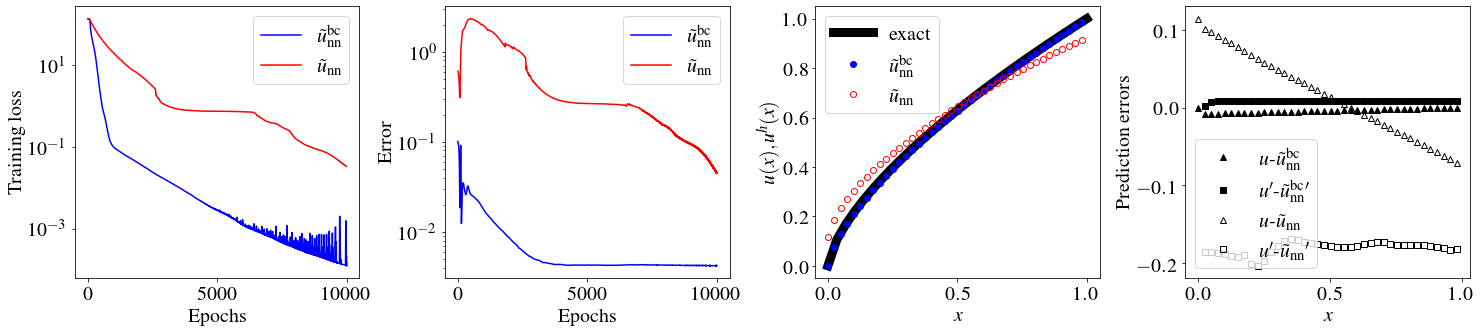

In [ ]:
#@title Neumann boundary conditions

numBatches = 1
num_epochs = 10000

#Domain boundary
a, b = 0.,1.

g1,g2 = 0.,1.


########################

def f(x):
  return (2./9.)*x**(-4./3)

def exact(x):
  return x**(2./3)

inputx = numpy.linspace(a+.01, b, num=100)
inputx = datareshapeMLP(inputx,numBatches)

#For plotting
x = numpy.linspace(a, b, num=200)
xe = numpy.linspace(a, b, num=30)


#########
#Dirichlet BC on LHS and RHS

layer_sizes = [1, 50, 50, 1]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def u(params, x):
    return phiA(x)*NN(params, x)+phig(x)

def loss(params, x):
    eq = upp_vect(params,x) + f_vect(x)
    return np.mean(eq**2)

g = grad(grad(u,1),1)
grad1 = grad(u,1)
grad1e = grad(exact,0)
u_vect = vmap(u, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))
e_vect = vmap(exact, (0,))
ep_vect = vmap(grad1e, (0,))
f_vect = vmap(f, (0,))


def run_training(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = update(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def update(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er


# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_training(num_epochs, opt_state, inputx, numBatches)

params = get_params(opt_state)

errorPhiA = e
lossPhiA = train_loss

exactSoln = e_vect(xe)
approxSolnA = u_vect(params, x)
umuhA = u_vect(params, x) - e_vect(x)
umuhpA = up_vect(params, x) - ep_vect(x)
###########################################################


#########
#No Dirichlet applied
def u(params, x):
    return NN(params, x)

def loss(params, x):
    eq = upp_vect(params,x) + f_vect(x)
    bc1 = u(params,a)-g1
    bc2 = u(params,b)-g2
    return np.mean(eq**2) + (bc1**2 + bc2**2)/2.

layer_sizes = [1, 50, 50, 1]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

g = grad(grad(u,1),1)
grad1 = grad(u,1)
grad1e = grad(exact,0)
u_vect = vmap(u, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))
e_vect = vmap(exact, (0,))
ep_vect = vmap(grad1e, (0,))
f_vect = vmap(f, (0,))


def run_training(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = update(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def update(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er


# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_training(num_epochs, opt_state, inputx, numBatches)

params = get_params(opt_state)

errorR = e
lossR = train_loss

exactSoln = e_vect(xe)
approxSolnR = u_vect(params, x)
umuhR = u_vect(params, x) - e_vect(x)
umuhpR = up_vect(params, x) - ep_vect(x)
###########################################################


plt.rcParams.update({'font.size': 20})
######
#Plots
# fig = plt.figure(figsize=(24, 5))
fig = plt.figure(figsize=(25, 5))
gs = gridspec.GridSpec(1, 4)
gs.update(wspace=.3)
# gs.update(hspace=.35)
# ax1 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])

ax1.plot(range(num_epochs),lossPhiA, color="blue", label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
ax1.plot(range(num_epochs),lossR, color="red", label='$\\tilde{u}_\mathrm{nn}$')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss')
ax1.legend(loc='best')
# ax1.text(-.1, 1., 'a', size=20, transform=ax1.transAxes)

ax2.plot(range(num_epochs),errorPhiA, color="blue", label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
ax2.plot(range(num_epochs),errorR, color="red", label='$\\tilde{u}_\mathrm{nn}$')
ax2.set_yscale('log')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Error')
ax2.legend(loc='best')
# ax2.text(-.15, 1., 'b', size=20, transform=ax2.transAxes)

ax3.plot(xe, exactSoln, color="black", label='exact',linewidth=9.0)
ax3.plot(x[::5], approxSolnA[::5], 'bo', label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
ax3.plot(x[::5], approxSolnR[::5], 'ro', mfc='none', label='$\\tilde{u}_\mathrm{nn}$')
ax3.legend(loc='best')
# ax3.set_xlim(0.,1.)
# ax3.set_ylim(-.6,.6)
ax3.set_xlabel('$x$')
ax3.set_ylabel('$u(x),u^h(x)$')
# ax3.text(-.15, 1., 'c', size=20, transform=ax3.transAxes)

ax4.plot(x[::5], umuhA[::5], "k^", label='$u$-$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
ax4.plot(x[::5], umuhpA[::5], "ks", label='$u\'$-$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$$\'$')
ax4.plot(x[::5], umuhR[::5], "k^", mfc='none', label='$u$-$\\tilde{u}_\mathrm{nn}$')
ax4.plot(x[::5], umuhpR[::5], "ks", mfc='none', label='$u\'$-$\\tilde{u}_\mathrm{nn}$$\'$')
ax4.legend(loc='best')
# ax4.set_xlim(0.,1.)
# ax4.set_ylim(-.6,.6)
ax4.set_xlabel('$x$')
ax4.set_ylabel('Prediction errors')
# ax4.text(-.17, 1., 'd', size=20, transform=ax4.transAxes)

plt.tight_layout()
fig.savefig('elasticRod-viii1.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

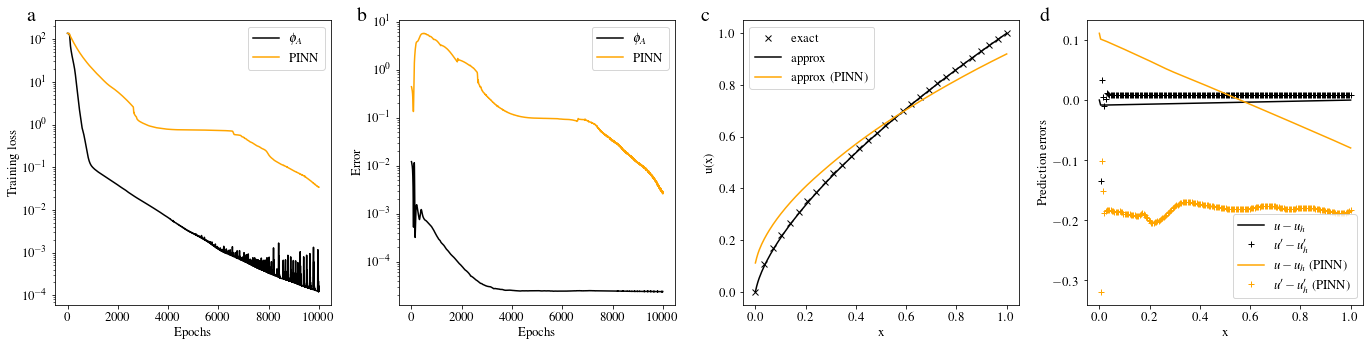

In [ ]:
#@title Extra plots

plt.rcParams.update({'font.size': 13})
######
#Plots
fig = plt.figure(figsize=(24, 5))

# Adds subplot on position 1
ax1 = fig.add_subplot(151)
# Adds subplot on position 2
ax2 = fig.add_subplot(152)
# Adds subplot on position 3
ax3 = fig.add_subplot(153)
# Adds subplot on position 2
ax4 = fig.add_subplot(154)

ax1.plot(range(num_epochs),lossPhiA, color="black", label='$\phi_A$')
ax1.plot(range(num_epochs),lossR, color="orange", label='PINN')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss')
ax1.legend(loc='best')
ax1.text(-.1, 1., 'a', size=20, transform=ax1.transAxes)

ax2.plot(range(num_epochs),errorPhiA, color="black", label='$\phi_A$')
ax2.plot(range(num_epochs),errorR, color="orange", label='PINN')
ax2.set_yscale('log')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Error')
ax2.legend(loc='best')
ax2.text(-.15, 1., 'b', size=20, transform=ax2.transAxes)

ax3.plot(xe, exactSoln, 'kx', label='exact')
ax3.plot(x, approxSolnA, color="black", label='approx')
ax3.plot(x, approxSolnR, color="orange", label='approx (PINN)')
ax3.legend(loc='best')
# ax3.set_xlim(0.,1.)
# ax3.set_ylim(-.6,.6)
ax3.set_xlabel('x')
ax3.set_ylabel('u(x)')
ax3.text(-.15, 1., 'c', size=20, transform=ax3.transAxes)

ax4.plot(x, umuhA, color="black", label='$u-u_h$')
ax4.plot(x, umuhpA, "k+", label='$u\'-u_h\'$')
ax4.plot(x, umuhR, color="orange", label='$u-u_h$ (PINN)')
ax4.plot(x, umuhpR, "+", color='orange', label='$u\'-u_h\'$ (PINN)')
ax4.legend(loc='best')
# ax4.set_xlim(0.,1.)
# ax4.set_ylim(-.6,.6)
ax4.set_xlabel('x')
ax4.set_ylabel('Prediction errors')
ax4.text(-.17, 1., 'd', size=20, transform=ax4.transAxes)

plt.tight_layout()
fig.savefig('elasticRod-viii.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

epoch:   0 loss: 48.459862
epoch: 1000 loss: 0.259302
epoch: 2000 loss: 0.029671
epoch:   0 loss: 48.459812
epoch: 1000 loss: 7.642870
epoch: 2000 loss: 7.539759
epoch:   0 loss: 48.459812
epoch: 1000 loss: 7.540407
epoch: 2000 loss: 7.536771
epoch:   0 loss: 48.460289
epoch: 1000 loss: 7.806066
epoch: 2000 loss: 0.004874
epoch:   0 loss: 0.500081
epoch: 1000 loss: 0.251545
epoch: 2000 loss: 0.128516
epoch: 3000 loss: 0.085167
epoch: 4000 loss: 0.037435
epoch: 5000 loss: 0.013675
epoch: 6000 loss: 0.008313
epoch: 7000 loss: 0.007256
epoch: 8000 loss: 0.044186
epoch: 9000 loss: 0.006023
epoch: 10000 loss: 0.023646
epoch: 11000 loss: 0.005490
epoch: 12000 loss: 0.005100
epoch: 13000 loss: 0.004736
epoch: 14000 loss: 0.005382
epoch: 15000 loss: 0.004235
epoch: 16000 loss: 0.006180
epoch: 17000 loss: 0.047349
epoch: 18000 loss: 0.003659
epoch: 19000 loss: 0.003516
epoch: 20000 loss: 0.003366
epoch: 21000 loss: 0.003604
epoch: 22000 loss: 0.004246
epoch: 23000 loss: 0.003398
epoch: 24000 lo

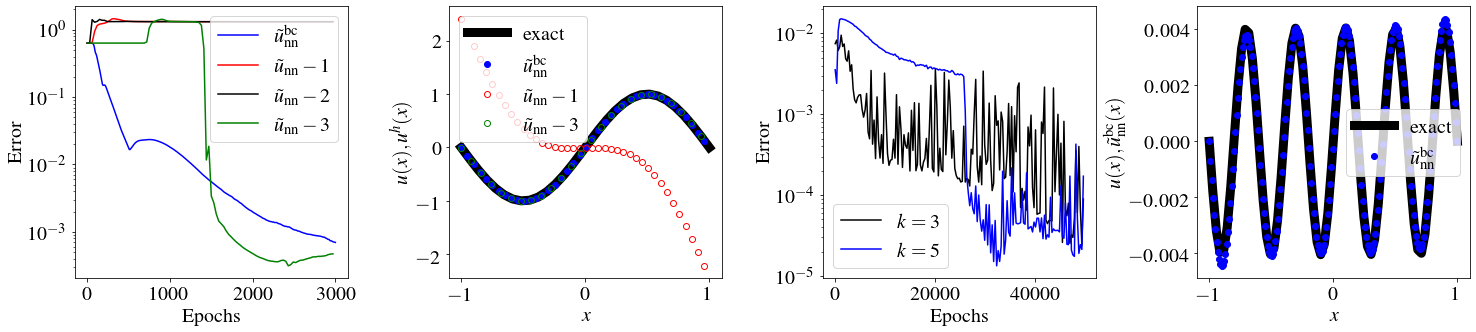

In [ ]:
#@title Sinusoidal body force

k=1.

numBatches = 1
num_epochs = 3000

#Domain boundary
a, b = -1.,1.

g1,g2 = 0.,0.


########################

def f(x):
  return np.pi**2*k**2*np.sin(k*np.pi*x)

def exact(x):
  return np.sin(k*np.pi*x)

inputx = numpy.linspace(a+.01, b, num=100)
inputx = datareshapeMLP(inputx,numBatches)

#For plotting
x = numpy.linspace(a, b, num=200)
xe = numpy.linspace(a, b, num=30)


#########
#Dirichlet BC on LHS and RHS

layer_sizes = [1, 30, 30, 1]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def u(params, x):
    return phiA(x)*NN(params, x)+phig(x)

def loss(params, x):
    eq = upp_vect(params,x) + f_vect(x)
    return np.mean(eq**2)

g = grad(grad(u,1),1)
grad1 = grad(u,1)
grad1e = grad(exact,0)
u_vect = vmap(u, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))
e_vect = vmap(exact, (0,))
ep_vect = vmap(grad1e, (0,))
f_vect = vmap(f, (0,))



def run_training(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = update(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def update(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er


# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_training(num_epochs, opt_state, inputx, numBatches)

params = get_params(opt_state)

errorPhiA = e
lossPhiA = train_loss

exactSoln = e_vect(xe)
approxSolnA = u_vect(params, x)
umuhA = u_vect(params, x) - e_vect(x)
umuhpA = up_vect(params, x) - ep_vect(x)
###########################################################


#########
#No Dirichlet applied
def u(params, x):
    return NN(params, x)

def loss(params, x):
    eq = upp_vect(params,x) + f_vect(x)
    bc1 = u(params,a)-g1
    bc2 = u(params,b)-g2
    return np.mean(eq**2) + (bc1**2 + bc2**2)/2.

layer_sizes = [1, 30, 30, 1]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

g = grad(grad(u,1),1)
grad1 = grad(u,1)
grad1e = grad(exact,0)
u_vect = vmap(u, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))
e_vect = vmap(exact, (0,))
ep_vect = vmap(grad1e, (0,))
f_vect = vmap(f, (0,))


def run_training(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = update(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def update(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er


# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_training(num_epochs, opt_state, inputx, numBatches)

params = get_params(opt_state)

errorR130301 = e
# lossR = train_loss

# exactSoln = e_vect(xe)
approxSolnR130301 = u_vect(params, x)
# umuhR = u_vect(params, x) - e_vect(x)
# umuhpR = up_vect(params, x) - ep_vect(x)
###########################################################

#########
#No Dirichlet applied
def u(params, x):
    return NN(params, x)

def loss(params, x):
    eq = upp_vect(params,x) + f_vect(x)
    bc1 = u(params,a)-g1
    bc2 = u(params,b)-g2
    return np.mean(eq**2) + (bc1**2 + bc2**2)/2.

layer_sizes = [1, 100, 100, 1]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

g = grad(grad(u,1),1)
grad1 = grad(u,1)
grad1e = grad(exact,0)
u_vect = vmap(u, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))
e_vect = vmap(exact, (0,))
ep_vect = vmap(grad1e, (0,))
f_vect = vmap(f, (0,))


def run_training(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = update(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def update(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er


# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_training(num_epochs, opt_state, inputx, numBatches)

params = get_params(opt_state)

errorR11001001 = e
# lossR = train_loss

# exactSoln = e_vect(xe)
approxSolnR11001001 = u_vect(params, x)
# umuhR = u_vect(params, x) - e_vect(x)
# umuhpR = up_vect(params, x) - ep_vect(x)
###########################################################

########
#No Dirichlet applied
def u(params, x):
    return NN(params, x)

def loss(params, x):
    eq = upp_vect(params,x) + f_vect(x)
    bc1 = u(params,a)-g1
    bc2 = u(params,b)-g2
    return np.mean(eq**2) + (bc1**2 + bc2**2)/2.

layer_sizes = [1, 100, 100, 100, 1]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

g = grad(grad(u,1),1)
grad1 = grad(u,1)
grad1e = grad(exact,0)
u_vect = vmap(u, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))
e_vect = vmap(exact, (0,))
ep_vect = vmap(grad1e, (0,))
f_vect = vmap(f, (0,))


def run_training(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = update(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def update(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er


# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_training(num_epochs, opt_state, inputx, numBatches)

params = get_params(opt_state)

errorR11001001001 = e
# lossR = train_loss

# exactSoln = e_vect(xe)
approxSolnR11001001001 = u_vect(params, x)
# umuhR = u_vect(params, x) - e_vect(x)
# umuhpR = up_vect(params, x) - ep_vect(x)
###########################################################




k=3.

numBatches = 1
num_epochsb = 50000

#Domain boundary
a, b = -1.,1.

g1,g2 = 0.,0.


########################

def f(x):
  return np.sin(k*np.pi*x)

def exact(x):
  return np.sin(k*np.pi*x)/(np.pi**2*k**2)

inputx = numpy.linspace(a+.01, b, num=200)
inputx = datareshapeMLP(inputx,numBatches)

#For plotting
x = numpy.linspace(a, b, num=200)
xe = numpy.linspace(a, b, num=30)


#########
#Dirichlet BC on LHS and RHS

layer_sizes = [1, 100, 100, 1]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def u(params, x):
    return phiA(x)*NN(params, x)+phig(x)

def loss(params, x):
    eq = upp_vect(params,x) + f_vect(x)
    return np.mean(eq**2)

g = grad(grad(u,1),1)
grad1 = grad(u,1)
grad1e = grad(exact,0)
u_vect = vmap(u, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))
e_vect = vmap(exact, (0,))
ep_vect = vmap(grad1e, (0,))
f_vect = vmap(f, (0,))



def run_training(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = update(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def update(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er


# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_training(num_epochsb, opt_state, inputx, numBatches)

params = get_params(opt_state)

errorPhiAk3 = e

exactSolnk3 = e_vect(xe)
approxSolnAk3 = u_vect(params, x)
###########################################################


k=5.

numBatches = 1
num_epochsb = 50000

#Domain boundary
a, b = -1.,1.

g1,g2 = 0.,0.

########################

def f(x):
  return np.sin(k*np.pi*x)

def exact(x):
  return np.sin(k*np.pi*x)/(np.pi**2*k**2)

inputx = numpy.linspace(a+.01, b, num=200)
inputx = datareshapeMLP(inputx,numBatches)

#For plotting
x = numpy.linspace(a, b, num=200)
xeb = numpy.linspace(a, b, num=70)


#########
#Dirichlet BC on LHS and RHS

layer_sizes = [1, 100, 100,  1]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def u(params, x):
    return phiA(x)*NN(params, x)+phig(x)

def loss(params, x):
    eq = upp_vect(params,x) + f_vect(x)
    return np.mean(eq**2)

g = grad(grad(u,1),1)
grad1 = grad(u,1)
grad1e = grad(exact,0)
u_vect = vmap(u, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))
e_vect = vmap(exact, (0,))
ep_vect = vmap(grad1e, (0,))
f_vect = vmap(f, (0,))



def run_training(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = update(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def update(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er


# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_training(num_epochsb, opt_state, inputx, numBatches)

params = get_params(opt_state)

errorPhiAk5 = e

exactSolnk5 = e_vect(xeb)
approxSolnAk5 = u_vect(params, x)
###########################################################




plt.rcParams.update({'font.size': 20})
######
#Plots
# fig = plt.figure(figsize=(24, 5))
fig = plt.figure(figsize=(25, 5))
gs = gridspec.GridSpec(1, 4)
gs.update(wspace=.37)
# gs.update(hspace=.35)
# ax1 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])

ax1.plot(range(num_epochs),errorPhiA, color="blue", label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
ax1.plot(range(num_epochs)[::30],errorR130301[::30], color="red", label='$\\tilde{u}_\mathrm{nn}-1$')
ax1.plot(range(num_epochs)[::30],errorR11001001[::30], color="black", label='$\\tilde{u}_\mathrm{nn}-2$')
ax1.plot(range(num_epochs)[::30],errorR11001001001[::30], color="green",  label='$\\tilde{u}_\mathrm{nn}-3$')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Error')
ax1.legend(loc='best')
# ax1.text(-.15, 1., 'a', size=20, transform=ax1.transAxes)

ax2.plot(xe, exactSoln, color="black", label='exact',linewidth=9.0)
ax2.plot(x[::5], approxSolnA[::5], 'bo', label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
ax2.plot(x[::5], approxSolnR130301[::5], 'ro', mfc='none', label='$\\tilde{u}_\mathrm{nn}-1$')
ax2.plot(x[::8], approxSolnR11001001001[::8], 'go', mfc='none', label='$\\tilde{u}_\mathrm{nn}-3$')
ax2.legend(loc='best')
# ax3.set_xlim(0.,1.)
# ax3.set_ylim(-.6,.6)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$u(x),u^h(x)$')
# ax2.text(-.15, 1., 'b', size=20, transform=ax2.transAxes)

ax3.plot(range(num_epochsb)[::300],errorPhiAk3[::300], color="black", label='$k=3$')
ax3.plot(range(num_epochsb)[::300],errorPhiAk5[::300], color="blue", label='$k=5$')
# ax3.plot(range(num_epochs),errorR11001001, color="blue", label='PINN(1-100-100-1)')
# ax3.plot(range(num_epochs),errorR11001001001, color="green", label='PINN(1-100-100-100-1)')
# ax3.set_title('1-100-100-1')
ax3.set_yscale('log')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Error')
ax3.legend(loc='best')
# ax3.text(-.15, 1., 'c', size=20, transform=ax3.transAxes)

ax4.plot(xeb, exactSolnk5, color="black", label='exact', linewidth=9.0)
ax4.plot(x, approxSolnAk5, 'bo', label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$')
ax4.legend(loc='best')
# ax4.set_title('$k=5$')
# ax3.set_xlim(0.,1.)
# ax3.set_ylim(-.6,.6)
ax4.set_xlabel('$x$')
ax4.set_ylabel('$u(x),\\tilde{u}_\mathrm{nn}^\mathrm{bc}(x)$')
# ax4.text(-.15, 1., 'd', size=20, transform=ax4.transAxes)

fig.savefig('elasticRod-sin1.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0)
plt.show()


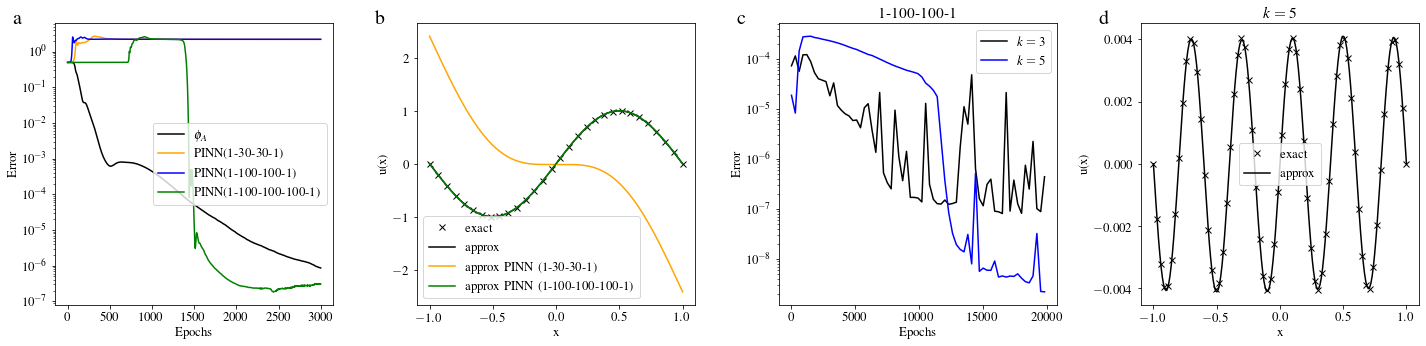

In [ ]:
#@title Extra plots
plt.rcParams.update({'font.size': 13})
######
#Plots
fig = plt.figure(figsize=(20, 5))

# Adds subplot on position 1
ax1 = fig.add_subplot(141)
# Adds subplot on position 2
ax2 = fig.add_subplot(142)
# Adds subplot on position 3
ax3 = fig.add_subplot(143)
# Adds subplot on position 2
ax4 = fig.add_subplot(144)

# ax1.plot(range(num_epochs),lossPhiA, color="black", label='$\phi_A$')
# ax1.plot(range(num_epochs),lossR, color="orange", label='PINN')
# ax1.set_yscale('log')
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Training loss')
# ax1.legend(loc='best')
# ax1.text(-.1, 1., 'a', size=20, transform=ax1.transAxes)

ax1.plot(range(num_epochs),errorPhiA, color="black", label='$\phi_A$')
ax1.plot(range(num_epochs),errorR130301, color="orange", label='PINN(1-30-30-1)')
ax1.plot(range(num_epochs),errorR11001001, color="blue", label='PINN(1-100-100-1)')
ax1.plot(range(num_epochs),errorR11001001001, color="green", label='PINN(1-100-100-100-1)')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Error')
ax1.legend(loc='best')
ax1.text(-.15, 1., 'a', size=20, transform=ax1.transAxes)

ax2.plot(xe, exactSoln, 'kx', label='exact')
ax2.plot(x, approxSolnA, color="black", label='approx')
ax2.plot(x, approxSolnR130301, color="orange", label='approx PINN (1-30-30-1)')
ax2.plot(x, approxSolnR11001001001, color="green", label='approx PINN (1-100-100-100-1)')
ax2.legend(loc='best')
# ax3.set_xlim(0.,1.)
# ax3.set_ylim(-.6,.6)
ax2.set_xlabel('x')
ax2.set_ylabel('u(x)')
ax2.text(-.15, 1., 'b', size=20, transform=ax2.transAxes)

ax3.plot(range(num_epochsb)[::300],errorPhiAk3[::300], color="black", label='$k=3$')
ax3.plot(range(num_epochsb)[::300],errorPhiAk5[::300], color="blue", label='$k=5$')
# ax3.plot(range(num_epochs),errorR11001001, color="blue", label='PINN(1-100-100-1)')
# ax3.plot(range(num_epochs),errorR11001001001, color="green", label='PINN(1-100-100-100-1)')
ax3.set_title('1-100-100-1')
ax3.set_yscale('log')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Error')
ax3.legend(loc='best')
ax3.text(-.15, 1., 'c', size=20, transform=ax3.transAxes)

ax4.plot(xeb, exactSolnk5, 'kx', label='exact')
ax4.plot(x, approxSolnAk5, color="black", label='approx')
ax4.legend(loc='best')
ax4.set_title('$k=5$')
# ax3.set_xlim(0.,1.)
# ax3.set_ylim(-.6,.6)
ax4.set_xlabel('x')
ax4.set_ylabel('u(x)')
ax4.text(-.15, 1., 'd', size=20, transform=ax4.transAxes)

plt.tight_layout()
fig.savefig('elasticRod-sin.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

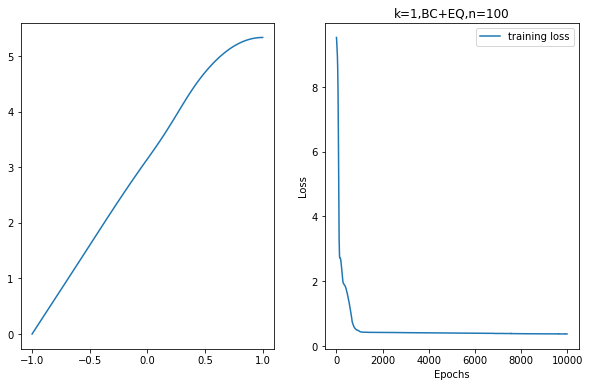

In [ ]:
#@title Heat equation
####

numBatches = 1
num_epochs = 10000

layer_sizes = [1, 30, 30, 1]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)


###########
#Dirichlet BC on LHS and RHS
# def u(params, x):
#     return phiA(x)*NN(params, x)+phig(x)

###########
#Dirichlet BC on LHS and Robin on RHS
def u(params, x):
    derb = grad(der,1)(params,b)
    t1 = rho1(x,a)*NN(params, x)
    t2 = ((rho1(x,a)*rho2(x,b))/(rho1(x,a)+rho2(x,b)))*(rho2(x,b)*NN(params, x)-c*rho1(x,a)*NN(params, x)-derb)
    t3 = ((rho1(x,a)*rho2(x,b))/(rho1(x,a)+rho2(x,b)))*(h-c*g1)
    return (t1-t2-t3+g1)

inputx = numpy.linspace(a, b, num=100)
x = numpy.linspace(a, b, num=100)
inputx = datareshapeMLP(inputx,numBatches)


g = grad(grad(u,1),1)
u_vect = vmap(u, (None, 0))
upp_vect = vmap(g, (None, 0))
f_vect = vmap(f, (0,))

def loss(params, inputx):
    eq = upp_vect(params,inputx) + f_vect(inputx)
    return np.mean(eq**2)

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state = run_training(num_epochs, opt_state, inputx, numBatches)

params = get_params(opt_state)

fig = plt.figure(figsize=(10, 6))

# Adds subplot on position 1
ax1 = fig.add_subplot(121)
# Adds subplot on position 2
ax2 = fig.add_subplot(122)

#fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, u_vect(params, x), label='approx')
ax2.plot(range(num_epochs),train_loss, label='training loss')
plt.title('k=1,BC+EQ,n=100')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
fig.savefig('myimage.svg', format='svg', dpi=1200)
plt.show()


epoch:   0 loss: 75.910133
epoch: 1000 loss: 11.910024
epoch: 2000 loss: 10.800421
epoch: 3000 loss: 10.309692
epoch: 4000 loss: 10.014930
epoch:   0 loss: -2.629757
epoch: 1000 loss: -4.796140
epoch: 2000 loss: -4.796139
epoch: 3000 loss: -4.796139
epoch: 4000 loss: -4.796139


<ipython-input-16-da00c9dea75d>:253: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


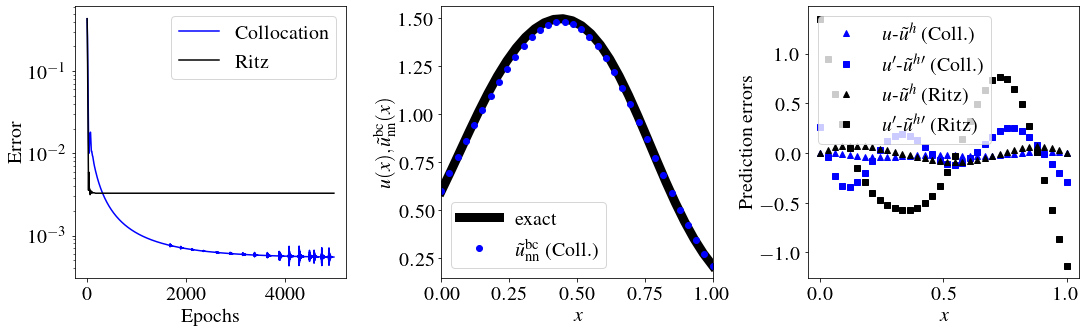

In [16]:
#@title RBF
numBatches = 1
num_epochs = 5000

gamma1,alpha1 = 9.,0.25
gamma2,alpha2 = 10.,0.6

#Domain boundary
a, b = 0.,1.

# a0,a1,a2 = 1.,-2.,10.
# g1,g2 = 0.5,-.5

# def f(x):
#   return a0+a1*x+a2*x**2

# def exact(x):
#   c1=g2-g1+a0/2+a1/6+a2/12
#   c2=g1
#   return -a0*x**2/2 - a1*x**3/6 - a2*x**4/12 + c1*x + c2


def exact(x):
  return np.exp(-gamma1*(x-alpha1)**2) + np.exp(-gamma2*(x-alpha2)**2)

f = grad(grad(exact,0),0)

g1=exact(0.)
g2=exact(1.)

# def f(x):
#   return -grad(grad(exact,0),0)


inputx = numpy.linspace(a, b, num=100)
inputx = datareshapeMLP(inputx,numBatches)

#For plotting
x = numpy.linspace(a, b, num=100)
xe = numpy.linspace(a, b, num=30)


#########
#RBF - collocation

layer_sizes = [1, 10, 1]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def u(params, x):
    return phiA(x)*NNRBF(params, x)+phig(x)

def loss(params, x):
    eq = upp_vect(params,x) - f_vect(x)
    return np.mean(eq**2)

g = grad(grad(u,1),1)
grad1 = grad(u,1)
grad1e = grad(exact,0)
u_vect = vmap(u, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))
e_vect = vmap(exact, (0,))
ep_vect = vmap(grad1e, (0,))
f_vect = vmap(f, (0,))


def run_training(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = update(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def update(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er


# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_training(num_epochs, opt_state, inputx, numBatches)

params = get_params(opt_state)

errorPhiA = e
lossPhiA = train_loss

exactSoln = e_vect(xe)
approxSolnA = u_vect(params, x)
umuhA = u_vect(params, x) - e_vect(x)
umuhpA = up_vect(params, x) - ep_vect(x)
###########################################################


####Ritz

def uR(params, x):
    return phiA(x)*NNRBF(params, x)+phig(x)

def A(params, x):
    return 0.5*(grad(uR,1)(params,x))**2

def L(params, x):
    return f(x)*uR(params,x)

A_vect = vmap(A, (None, 0))
L_vect = vmap(L, (None, 0))
u_vect = vmap(uR, (None, 0))

def lossR(params, inputx):
    eq = A_vect(params,inputx) + L_vect(params,inputx)
    return np.trapz(eq,inputx)

params = initialize_mlp(layer_sizes, key)

g = grad(grad(uR,1),1)
grad1 = grad(uR,1)
u_vect = vmap(uR, (None, 0))
upp_vect = vmap(g, (None, 0))
up_vect = vmap(grad1, (None, 0))


def run_trainingR(num_epochs, opt_state, inputs, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        x=inputs[batch,:]
        params, opt_state, loss, Er = updateR(params, x, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))

    return train_loss, opt_state, E

@jit
def updateR(params, x, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossR)(params, x)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, x)
    return get_params(opt_state), opt_state, value, Er


# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingR(num_epochs, opt_state, inputx, numBatches)

params = get_params(opt_state)

errorR = e
lossR = train_loss

exactSoln = e_vect(xe)
approxSolnR = u_vect(params, x)
umuhR = u_vect(params, x) - e_vect(x)
umuhpR = up_vect(params, x) - ep_vect(x)








plt.rcParams.update({'font.size': 20})
######
#Plots
fig = plt.figure(figsize=(18, 5))
gs = gridspec.GridSpec(1, 3)
gs.update(wspace=.35)
# gs.update(hspace=.35)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
# ax0 = plt.subplot(gs[0, 0])
# ax4 = plt.subplot(gs[0, 3])

# ax0.plot(range(num_epochs),lossPhiA, color="blue", label='Collocation')
# ax0.plot(range(num_epochs),lossR, color="black", label='Ritz')
# ax0.set_yscale('log')
# ax0.set_xlabel('Epochs')
# ax0.set_ylabel('Training loss')
# ax0.legend(loc='best')
# # ax1.text(-.1, 1., 'a', size=20, transform=ax1.transAxes)


ax1.plot(range(num_epochs),errorPhiA, color="blue", label='Collocation')
ax1.plot(range(num_epochs),errorR, color="black", label='Ritz')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Error')
ax1.legend(loc='best')
# ax1.text(-.1, 1., 'a', size=20, transform=ax1.transAxes)

ax2.plot(xe, exactSoln, color="black", linewidth=9.0, label='exact')
ax2.plot(x[::3], approxSolnA[::3], 'bo', label='$\\tilde{u}_\mathrm{nn}^\mathrm{bc}$ (Coll.)')
ax2.legend(loc='best')
ax2.set_xlim(0.,1.)
# ax3.set_ylim(-.6,.6)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$u(x),\\tilde{u}_\mathrm{nn}^\mathrm{bc}(x)$')
# ax3.text(-.15, 1., 'c', size=20, transform=ax3.transAxes)

ax3.plot(x[::3], umuhA[::3], "b^", label='$u$-$\\tilde{u}^h$ (Coll.)')
ax3.plot(x[::3], umuhpA[::3], "bs", label='$u\'$-$\\tilde{u}^h$$\'$ (Coll.)')
ax3.plot(x[::3], umuhR[::3], "k^",  label='$u$-$\\tilde{u}^h$ (Ritz)')
ax3.plot(x[::3], umuhpR[::3], "ks",  label='$u\'$-$\\tilde{u}^h$$\'$ (Ritz)')
ax3.legend(loc='best')
ax3.set_xlabel('$x$')
ax3.set_ylabel('Prediction errors')

plt.tight_layout()
fig.savefig('elasticRod-RBF.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0)
plt.show()
